In [4]:
import time
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from functools import partial
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
from bayes_opt import BayesianOptimization
from IPython.html.widgets import FloatProgress
from IPython.display import display

/home/halaka/tracking_venv/lib64/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
use_cuda

True

In [6]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, n_hidden, first_hidden = None, center_hidden = None , last_hidden = 2):
        self.hidden_number = 0
        if first_hidden == None:
            first_hidden = input_dim
        if center_hidden == None:
            center_hidden = first_hidden
        super(LogisticRegressionModel, self).__init__()
        self.leyer_list = nn.ModuleList()
        layer_w = input_dim
        hidden_dim = first_hidden
        for i in range(int(n_hidden)+1):
            self.hidden_number += n_hidden
            self.leyer_list.append(nn.Linear(layer_w, hidden_dim))
            if i < (n_hidden/2)-1:
                layer_w = hidden_dim
                hidden_dim = (int)((i+1)*(2*(center_hidden-first_hidden)/n_hidden)+first_hidden)
            else:
                layer_w = hidden_dim
                hidden_dim = (int)((i-n_hidden/2+1)*(2*(last_hidden-center_hidden)/n_hidden)+center_hidden)
        self.leyer_list.append(nn.Linear(layer_w, 1))
    def forward(self, x): 
        Relu = nn.LeakyReLU()
        Sigm = nn.Sigmoid()
        for layer in self.leyer_list[:-1]:
            x = Relu(layer(x))
        y = Sigm(self.leyer_list[-1](x))
        return y

In [7]:
from torch.utils import data

class MyDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, features, labels):
        'Initialization'
        self.labels = labels
        self.features = features

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.features)

    def __getitem__(self, index):
        'Generates one sample of data'
        x = self.features[index]
        y = self.labels[index]
        return x, y


In [8]:
def acc(model, loss_fun, features, targets):
    targets = targets.to(device).view(-1,1)
    start = time.time()
    outputs = model(features.to(device))
    end = time.time()
    elapsed_time = (end - start)
    loss_eval = loss_fun(outputs, targets)
    pred = (outputs>0.5).float()
    precision = precision_score(pred.detach().cpu(), targets.detach().cpu())
    recall= recall_score(pred.cpu(), targets.cpu(), zero_division=0)
    pred = (pred.to(device) == targets).sum()
    return pred.float()/len(outputs), loss_eval.detach(), precision, recall, elapsed_time

In [9]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,4, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["train_loss"]))
    ax[0].plot(x, run_hist["train_loss"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["test_loss"],'r', marker='.', label="test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["train_acc"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["test_acc"],'r', marker='.', label="test accuracy")
    ax[1].legend()
    ax[2].plot(x, run_hist["train_precision"],'b', marker='.', label="train precision")
    ax[2].plot(x, run_hist["test_precision"],'r', marker='.', label="test precision")
    ax[2].legend()
    ax[3].plot(x, run_hist["train_recall"],'b', marker='.', label="train recall")
    ax[3].plot(x, run_hist["test_recall"],'r', marker='.', label="test recall")
    ax[3].legend()

In [10]:
def plot_roc(x, y, model):
    output = model(x.to(device))
    fpr, tpr, thresholds = roc_curve(y.cpu().detach().numpy(), output.cpu().detach().numpy())
    plt.figure()
    lw = 2
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc_val

In [11]:
def train(model, training_set, test_data, stat_dict, epochs, lr_rate, batch_size, verbose = 0):
    input_dim = X_train.shape[1]
    X_test, y_test = test_data
    loss_fun = torch.nn.BCELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr_rate)
    model.to(device)
    n_epoch = len(stat_dict["train_acc"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)
    f = FloatProgress(min=n_epoch, max=epochs)
    display(f)
    for epoch in range(n_epoch, epochs):
        f.value = epoch
        training_generator = utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True)
        train_acc, train_loss, train_precision, train_recall, _= acc(model, loss_fun, X_train, y_train)
        test_acc, test_loss, test_precision, test_recall, elapsed_time = acc(model, loss_fun, X_test, y_test)
        for batch_features, batch_targets in training_generator:
            batch_features, batch_targets = batch_features.to(device).view(-1,input_dim), batch_targets.to(device).view(-1,1)
            def closure(batch_features, batch_targets):
                optimizer.zero_grad()
                pred = model(batch_features)
                loss_val = loss_fun(pred, batch_targets)
                loss_val.backward()
            optimizer.step(closure(batch_features, batch_targets))
        scheduler.step()
        stat_dict["test_loss"].append(test_loss)
        stat_dict["test_acc"].append(test_acc)
        stat_dict["test_precision"].append(test_precision)
        stat_dict["test_recall"].append(test_recall)
        stat_dict["train_loss"].append(train_loss)    
        stat_dict["train_acc"].append(train_acc)
        stat_dict["train_precision"].append(train_precision)    
        stat_dict["train_recall"].append(train_recall)
        stat_dict["elapsed_time"].append(elapsed_time)
        if verbose == 1:
            print("epoch {0}".format(epoch+1))
            print("train: loss {0:.4f}, acc = {1:.4f}, precision = {2:.4f}, recall = {3:.4f}".format(train_loss, train_acc, train_precision, train_recall))
            print("test:  loss {0:.4f}, acc = {1:.4f}, precision = {2:.4f}, recall = {3:.4f}, time= {4}".format( test_loss, test_acc, test_precision, test_recall, elapsed_time))
            if epoch!=0 and epoch%100==0:
                plot_training_classification(stat_dict)
                auc_val = plot_roc(X_test, y_test, model)
    f.value = epochs
    if verbose == 0:
        print("train: loss {0:.4f}, acc = {1:.4f}, precision= {2:.4f}, recall = {3:.4f}".format(train_loss, train_acc, train_precision, train_recall))
        print("test:  loss {0:.4f}, acc = {1:.4f}, precision = {2:.4f}, recall = {3:.4f}".format( test_loss, test_acc, test_precision, test_recall))
        print("time: {}, number of hidden neurons: {}".format(elapsed_time, model.hidden_number))
        plot_training_classification(stat_dict)
        auc_val = plot_roc(X_test, y_test, model)

In [12]:
train_data_file = "final_data.csv"
data = pd.read_csv(train_data_file)
data = data.drop(["Unnamed: 0", "track_chi2", "particle_key", "track_charge", "particle_fullInfo", "particle_hasScifi", "particle_pid", "track_chi2", "track_phi", "track_position_phi", 'particle_eta', 'particle_fullInfo',
       'particle_ovtx_x',
       'particle_ovtx_y', 'particle_ovtx_z', 'particle_evtx_x',
       'particle_evtx_y', 'particle_evtx_z', 'particle_p', 'particle_phi',
       'particle_pid', 'particle_pt', 'particle_px', 'particle_py',
       'particle_pz'] , axis=1).astype(np.float64)

In [13]:
featuresTAll = data[((data.particle_isDown == 1)&(data.particle_hasVelo == 0)&(data.particle_isLong_andUT == 0))].drop(['particle_hasUT','particle_hasVelo', 'particle_isDown', 'particle_isDown_noVelo', 'particle_isLong', 'particle_isLong_andUT'], axis = 1)
featuresFAll = data[((data.particle_isDown == 0)|(data.particle_hasVelo == 1)&(data.particle_isLong_andUT == 0))].drop(['particle_hasUT','particle_hasVelo', 'particle_isDown', 'particle_isDown_noVelo', 'particle_isLong', 'particle_isLong_andUT'], axis = 1)
print(len(featuresTAll), len(featuresFAll))

1769906 3549788


In [14]:
featuresTAll["target"]=1.0
featuresFAll["target"]=0.0
featuresAll = featuresTAll.append(featuresFAll.sample(len(featuresTAll)), ignore_index=True)
featuresAll.columns.values

array(['track_chi2PerDoF', 'track_nLHCbIDs', 'track_p',
       'track_position_r', 'track_position_x', 'track_position_y',
       'track_pt', 'track_tx', 'track_ty', 'track_pseudoRapidity',
       'target'], dtype=object)

In [15]:
featuresAll = featuresAll.sample(1000000)
targets=(featuresAll.target.values).astype(np.float64)
features=featuresAll.drop(["target"], axis=1).values
print(len(targets),len(features))

1000000 1000000


In [16]:
scaler = StandardScaler()
scaler.fit(features)
X = scaler.transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size = 0.2)

In [17]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)
X_train.shape

torch.Size([800000, 10])

In [18]:
class Score(float):
    def __new__(self, loss, acc, recall, time, model_cost):
        score = acc - model_cost
        return float.__new__(self, score)
    def __init__(self, loss, acc, recall, time, model_cost):
        score = acc - model_cost
        float.__init__(score)
        self.loss = loss
        self.acc = acc
        self.recall= recall
        self.time = time

In [32]:
def fit_with(epochs, n_hiden, first_hiden, center_hiden, last_hiden, lr, batch_size, return_model=True, verbose=0, cost_ratio=0.1):
    params = [int(n_hiden), int(first_hiden), int(center_hiden), int(last_hiden)]
    input_dim = X_train.shape[1]
    output_dim = 1
    model = LogisticRegressionModel(input_dim, *params)
    stat_dict = {
        "train_loss" : [],
        "test_loss" : [],
        "train_acc" : [],
        "test_acc" : [],
        "train_precision" : [],
        "test_precision" : [],
        "train_recall" : [],
        "test_recall" : [],
        "elapsed_time": []
    }
    training_set = MyDataset(X_train, y_train)
    test_data = (X_test, y_test)
    train(model, training_set, test_data, stat_dict, epochs, lr, int(batch_size), verbose)
    elapsed_time = mean(stat_dict["elapsed_time"][-5:])
    score = Score(stat_dict["test_loss"][-1].item(), stat_dict["test_acc"][-1].item(), stat_dict["test_recall"][-1].item(), elapsed_time, cost_ratio*model.hidden_number/225)
    if return_model:
        return model, stat_dict
    else:
        return score

FloatProgress(value=0.0, max=200.0)

epoch 1
train: loss 0.7368, acc = 0.4993, precision = 1.0000, recall = 0.4994
test:  loss 0.7360, acc = 0.5007, precision = 1.0000, recall = 0.5007, time= 0.0009105205535888672
epoch 2
train: loss 0.6964, acc = 0.4994, precision = 1.0000, recall = 0.4994
test:  loss 0.6961, acc = 0.5007, precision = 1.0000, recall = 0.5007, time= 0.0009300708770751953
epoch 3
train: loss 0.6705, acc = 0.5933, precision = 0.4458, recall = 0.6314
test:  loss 0.6713, acc = 0.5911, precision = 0.4419, recall = 0.6309, time= 0.0009338855743408203
epoch 4
train: loss 0.6343, acc = 0.6456, precision = 0.7271, recall = 0.6247
test:  loss 0.6348, acc = 0.6449, precision = 0.7249, recall = 0.6254, time= 0.0009176731109619141
epoch 5
train: loss 0.5845, acc = 0.6885, precision = 0.8150, recall = 0.6500
test:  loss 0.5851, acc = 0.6882, precision = 0.8150, recall = 0.6506, time= 0.0009396076202392578
epoch 6
train: loss 0.5390, acc = 0.7328, precision = 0.8217, recall = 0.6973
test:  loss 0.5387, acc = 0.7333, pre

epoch 48
train: loss 0.3761, acc = 0.8500, precision = 0.8859, recall = 0.8262
test:  loss 0.3764, acc = 0.8500, precision = 0.8848, recall = 0.8275, time= 0.0009195804595947266
epoch 49
train: loss 0.3751, acc = 0.8503, precision = 0.8910, recall = 0.8237
test:  loss 0.3756, acc = 0.8504, precision = 0.8895, recall = 0.8252, time= 0.0009350776672363281
epoch 50
train: loss 0.3747, acc = 0.8504, precision = 0.8888, recall = 0.8252
test:  loss 0.3752, acc = 0.8500, precision = 0.8872, recall = 0.8261, time= 0.0009217262268066406
epoch 51
train: loss 0.3754, acc = 0.8499, precision = 0.8854, recall = 0.8264
test:  loss 0.3762, acc = 0.8496, precision = 0.8838, recall = 0.8276, time= 0.0009477138519287109
epoch 52
train: loss 0.3738, acc = 0.8510, precision = 0.8893, recall = 0.8257
test:  loss 0.3742, acc = 0.8508, precision = 0.8879, recall = 0.8269, time= 0.0009541511535644531
epoch 53
train: loss 0.3736, acc = 0.8510, precision = 0.8842, recall = 0.8288
test:  loss 0.3743, acc = 0.850

epoch 95
train: loss 0.3672, acc = 0.8531, precision = 0.8904, recall = 0.8283
test:  loss 0.3679, acc = 0.8531, precision = 0.8889, recall = 0.8299, time= 0.0009348392486572266
epoch 96
train: loss 0.3673, acc = 0.8531, precision = 0.8885, recall = 0.8294
test:  loss 0.3678, acc = 0.8531, precision = 0.8873, recall = 0.8308, time= 0.0009191036224365234
epoch 97
train: loss 0.3667, acc = 0.8534, precision = 0.8916, recall = 0.8280
test:  loss 0.3672, acc = 0.8534, precision = 0.8902, recall = 0.8295, time= 0.0009343624114990234
epoch 98
train: loss 0.3669, acc = 0.8533, precision = 0.8849, recall = 0.8321
test:  loss 0.3677, acc = 0.8535, precision = 0.8837, recall = 0.8337, time= 0.0009596347808837891
epoch 99
train: loss 0.3666, acc = 0.8538, precision = 0.8873, recall = 0.8313
test:  loss 0.3671, acc = 0.8539, precision = 0.8859, recall = 0.8329, time= 0.0009229183197021484
epoch 100
train: loss 0.3659, acc = 0.8537, precision = 0.8939, recall = 0.8271
test:  loss 0.3665, acc = 0.85

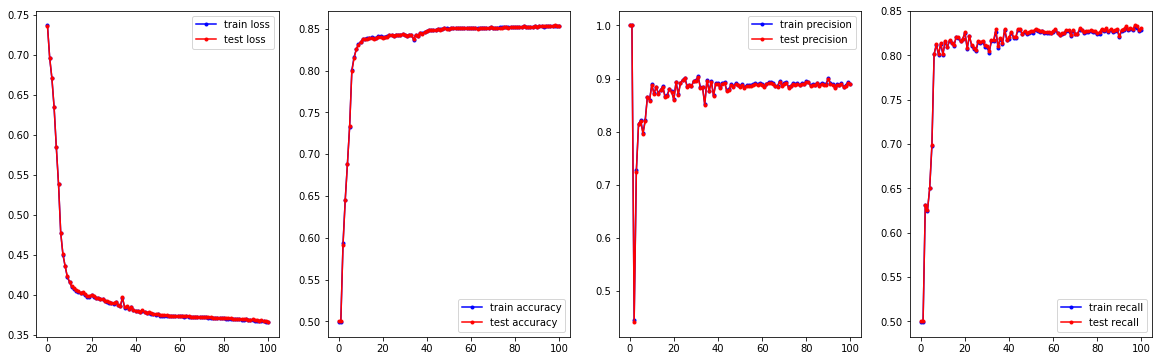

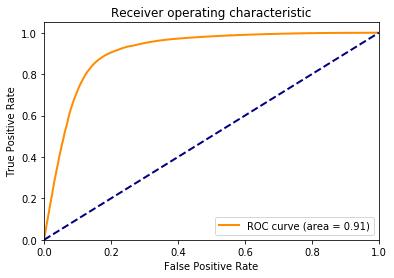

epoch 102
train: loss 0.3655, acc = 0.8540, precision = 0.8908, recall = 0.8295
test:  loss 0.3660, acc = 0.8545, precision = 0.8897, recall = 0.8315, time= 0.0009315013885498047
epoch 103
train: loss 0.3654, acc = 0.8540, precision = 0.8932, recall = 0.8280
test:  loss 0.3659, acc = 0.8543, precision = 0.8918, recall = 0.8299, time= 0.0009362697601318359
epoch 104
train: loss 0.3654, acc = 0.8540, precision = 0.8926, recall = 0.8282
test:  loss 0.3659, acc = 0.8542, precision = 0.8914, recall = 0.8299, time= 0.0009210109710693359
epoch 105
train: loss 0.3653, acc = 0.8541, precision = 0.8923, recall = 0.8286
test:  loss 0.3658, acc = 0.8545, precision = 0.8911, recall = 0.8306, time= 0.0009648799896240234
epoch 106
train: loss 0.3653, acc = 0.8541, precision = 0.8905, recall = 0.8299
test:  loss 0.3658, acc = 0.8545, precision = 0.8893, recall = 0.8317, time= 0.0009272098541259766
epoch 107
train: loss 0.3652, acc = 0.8542, precision = 0.8907, recall = 0.8299
test:  loss 0.3657, acc =

epoch 148
train: loss 0.3632, acc = 0.8551, precision = 0.8883, recall = 0.8327
test:  loss 0.3638, acc = 0.8551, precision = 0.8870, recall = 0.8341, time= 0.0009226799011230469
epoch 149
train: loss 0.3631, acc = 0.8551, precision = 0.8925, recall = 0.8301
test:  loss 0.3635, acc = 0.8554, precision = 0.8915, recall = 0.8318, time= 0.0009181499481201172
epoch 150
train: loss 0.3631, acc = 0.8552, precision = 0.8936, recall = 0.8296
test:  loss 0.3634, acc = 0.8555, precision = 0.8927, recall = 0.8312, time= 0.0009272098541259766
epoch 151
train: loss 0.3630, acc = 0.8552, precision = 0.8905, recall = 0.8315
test:  loss 0.3635, acc = 0.8554, precision = 0.8895, recall = 0.8330, time= 0.0009198188781738281
epoch 152
train: loss 0.3629, acc = 0.8552, precision = 0.8929, recall = 0.8299
test:  loss 0.3634, acc = 0.8553, precision = 0.8917, recall = 0.8314, time= 0.0009281635284423828
epoch 153
train: loss 0.3629, acc = 0.8552, precision = 0.8921, recall = 0.8305
test:  loss 0.3634, acc =

epoch 194
train: loss 0.3625, acc = 0.8553, precision = 0.8923, recall = 0.8306
test:  loss 0.3630, acc = 0.8555, precision = 0.8913, recall = 0.8321, time= 0.0009372234344482422
epoch 195
train: loss 0.3625, acc = 0.8554, precision = 0.8921, recall = 0.8308
test:  loss 0.3629, acc = 0.8556, precision = 0.8910, recall = 0.8323, time= 0.0009274482727050781
epoch 196
train: loss 0.3625, acc = 0.8554, precision = 0.8923, recall = 0.8306
test:  loss 0.3629, acc = 0.8555, precision = 0.8912, recall = 0.8321, time= 0.0009188652038574219
epoch 197
train: loss 0.3624, acc = 0.8554, precision = 0.8927, recall = 0.8304
test:  loss 0.3629, acc = 0.8555, precision = 0.8915, recall = 0.8319, time= 0.0009224414825439453
epoch 198
train: loss 0.3624, acc = 0.8555, precision = 0.8914, recall = 0.8313
test:  loss 0.3629, acc = 0.8556, precision = 0.8903, recall = 0.8327, time= 0.0009255409240722656
epoch 199
train: loss 0.3624, acc = 0.8554, precision = 0.8928, recall = 0.8303
test:  loss 0.3629, acc =

In [36]:
model, stat_dict = fit_with(epochs=200, n_hiden=6, first_hiden=12, center_hiden=7, last_hiden=3, lr=0.01, batch_size=30000, return_model=True, verbose=1, cost_ratio=0.02)

In [37]:
model.hidden_number

42

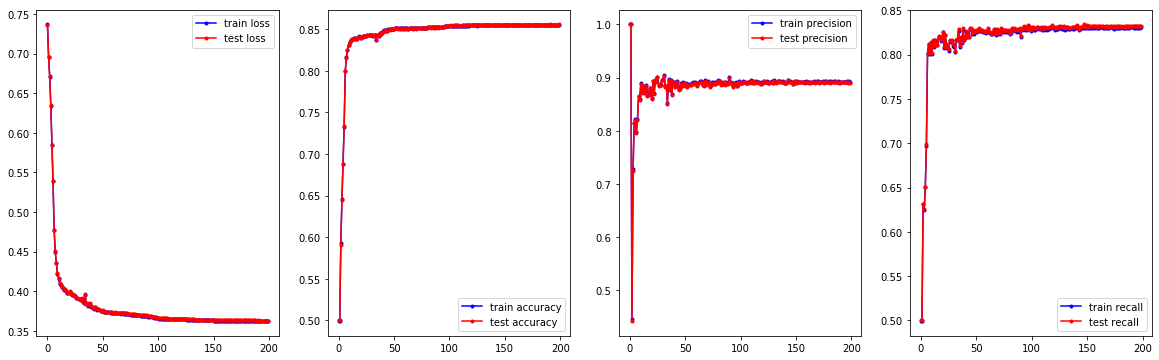

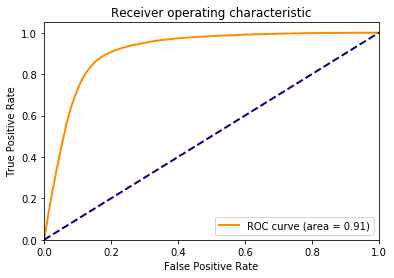

In [38]:
plot_training_classification(stat_dict)
auc_val = plot_roc(X_test, y_test, model)

In [51]:
pbounds = {'n_hiden': (4, 15), "first_hiden": (5, 15), "center_hiden": (5, 15), "last_hiden": (5, 15), 'lr': (1e-3, 1e-2), "batch_size": (5e+3, 5e+4)}

epochs=80
fit_with_partial = partial(fit_with, epochs, return_model=False, cost_ratio=0.02)

|   iter    |  target   | batch_... | center... | first_... | last_h... |    lr     |  n_hiden  |
-------------------------------------------------------------------------------------------------


FloatProgress(value=0.0, max=80.0)

train: loss 0.3709, acc = 0.8494, precision= 0.8929, recall = 0.8211
test:  loss 0.3733, acc = 0.8482, precision = 0.8906, recall = 0.8214
time: 0.0008358955383300781, number of hidden neurons: 30


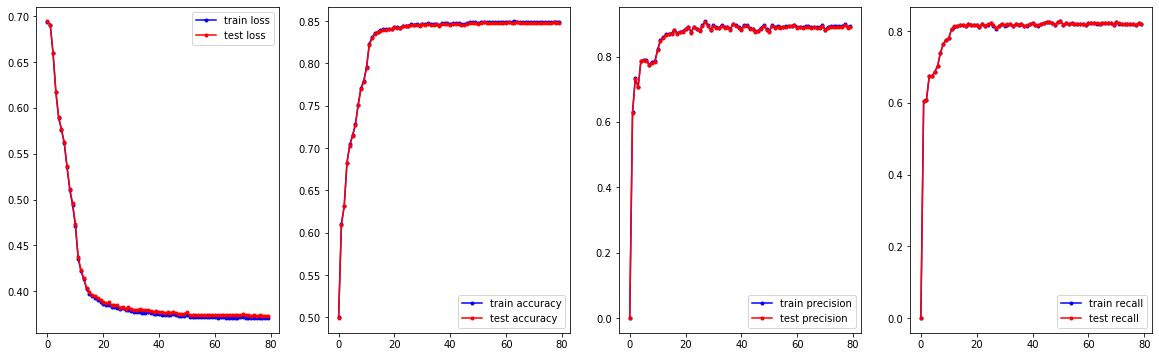

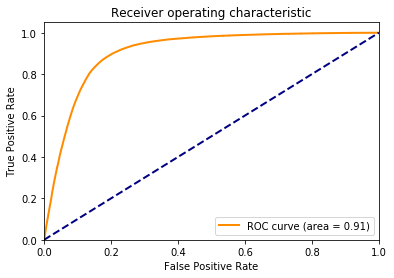

|  1        |  0.8456   |  2.377e+0 |  12.2     |  5.001    |  8.023    |  0.002321 |  5.016    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3452, acc = 0.8621, precision= 0.8894, recall = 0.8431
test:  loss 0.3470, acc = 0.8621, precision = 0.8886, recall = 0.8442
time: 0.0013210773468017578, number of hidden neurons: 132


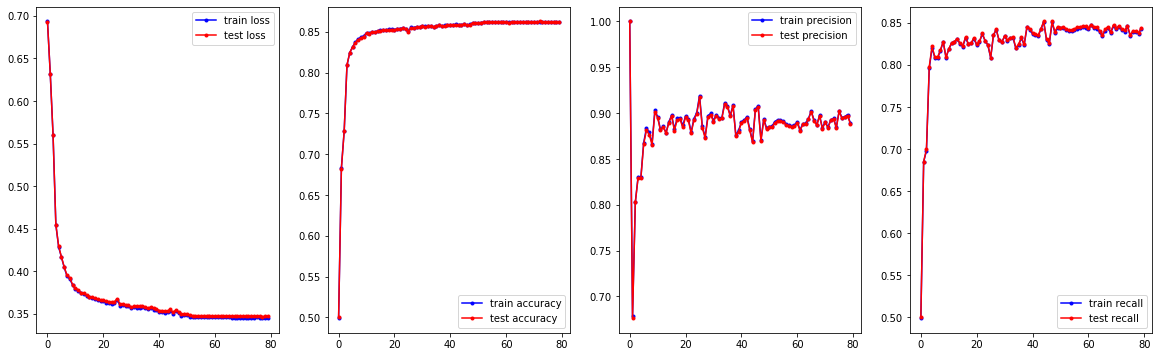

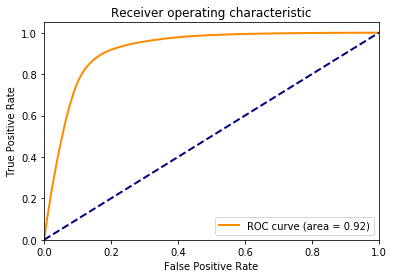

|  2        |  0.8504   |  1.338e+0 |  8.456    |  8.968    |  10.39    |  0.004773 |  11.54    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3710, acc = 0.8522, precision= 0.8888, recall = 0.8280
test:  loss 0.3724, acc = 0.8519, precision = 0.8871, recall = 0.8290
time: 0.0012476444244384766, number of hidden neurons: 110


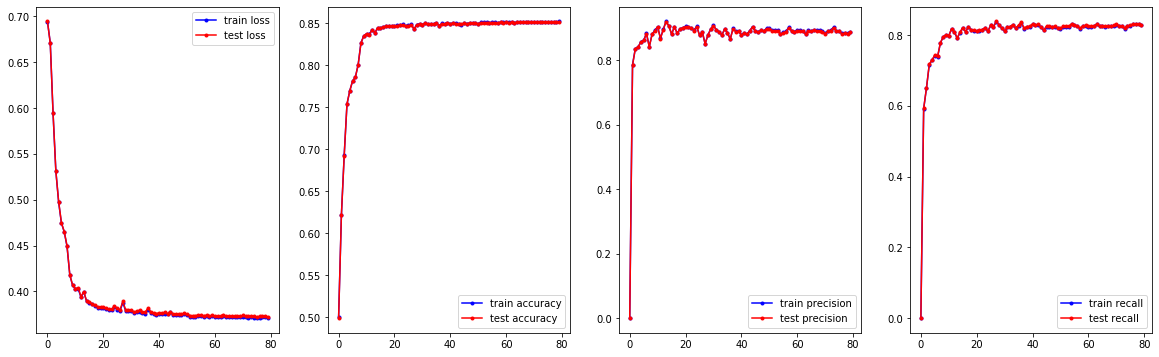

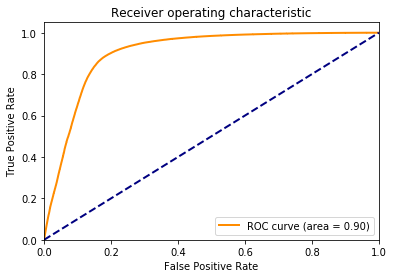

|  3        |  0.8421   |  1.42e+04 |  13.78    |  5.274    |  11.7     |  0.004756 |  10.15    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3389, acc = 0.8649, precision= 0.8953, recall = 0.8437
test:  loss 0.3403, acc = 0.8647, precision = 0.8937, recall = 0.8451
time: 0.0013315677642822266, number of hidden neurons: 132


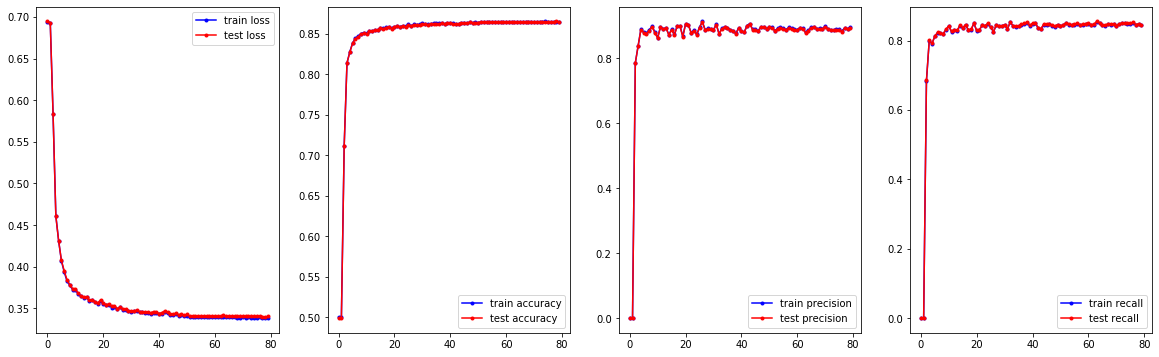

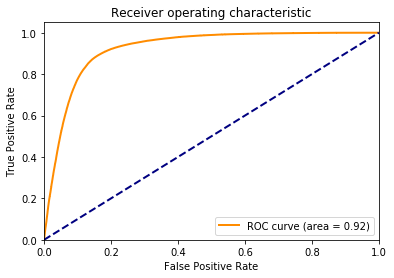

|  4        |  0.853    |  1.132e+0 |  6.981    |  13.01    |  14.68    |  0.003821 |  11.62    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.4146, acc = 0.8354, precision= 0.8607, recall = 0.8189
test:  loss 0.4162, acc = 0.8346, precision = 0.8586, recall = 0.8197
time: 0.0015094280242919922, number of hidden neurons: 182


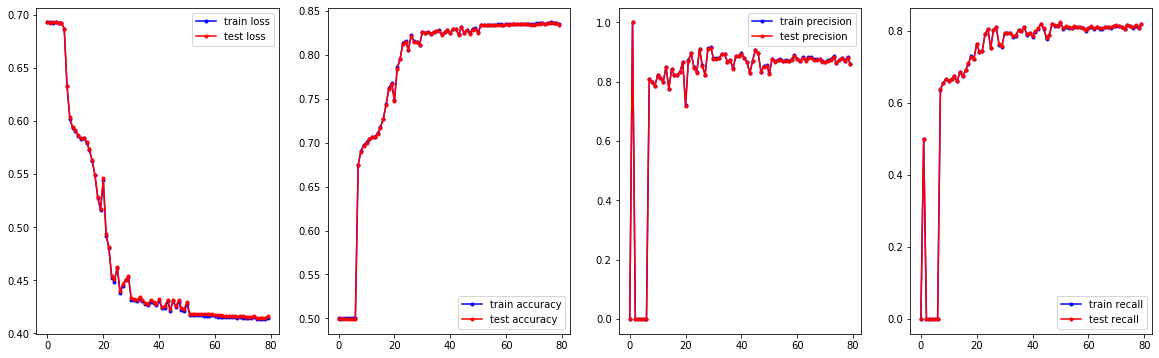

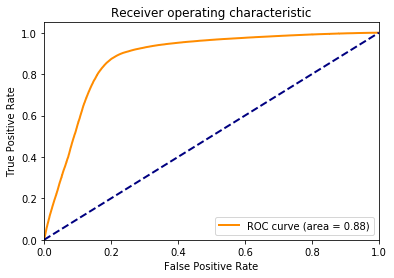

|  5        |  0.8185   |  4.444e+0 |  13.95    |  5.85     |  5.391    |  0.002528 |  13.66    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3324, acc = 0.8666, precision= 0.8911, recall = 0.8492
test:  loss 0.3345, acc = 0.8660, precision = 0.8899, recall = 0.8495
time: 0.0010123252868652344, number of hidden neurons: 56


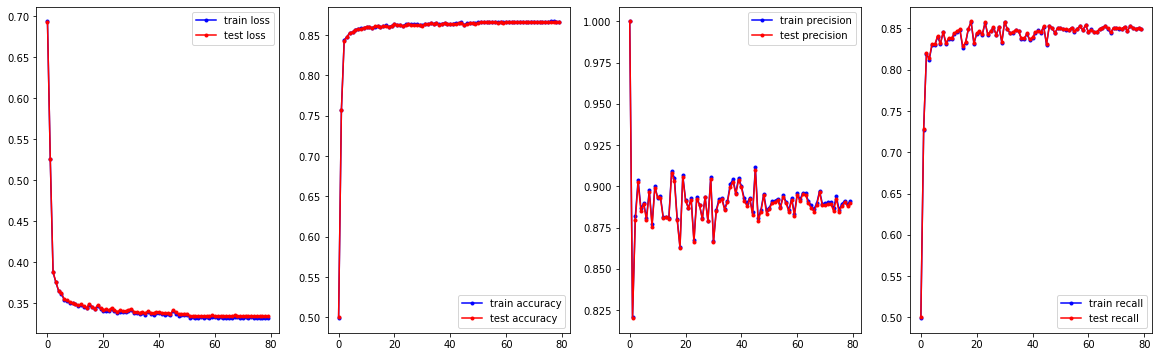

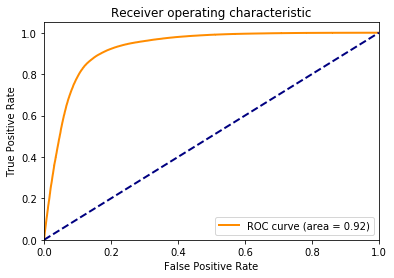

|  6        |  0.861    |  9.426e+0 |  9.211    |  14.58    |  10.33    |  0.007227 |  7.471    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3743, acc = 0.8481, precision= 0.8829, recall = 0.8252
test:  loss 0.3756, acc = 0.8467, precision = 0.8811, recall = 0.8247
time: 0.0014109611511230469, number of hidden neurons: 156


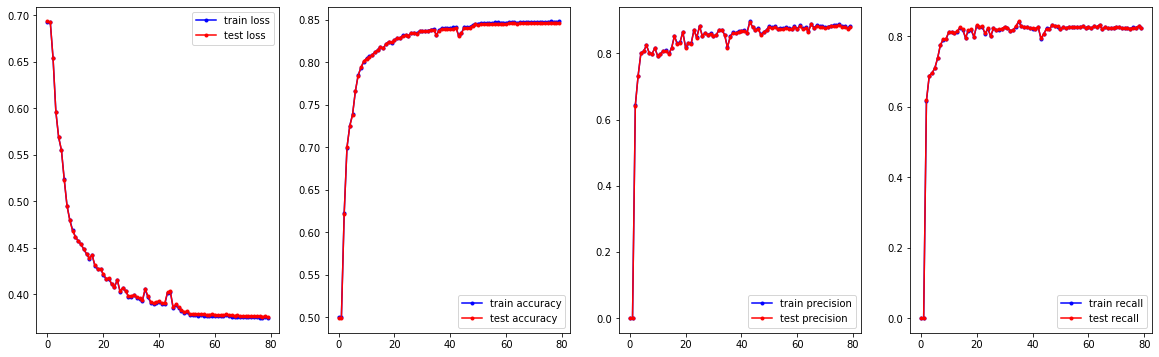

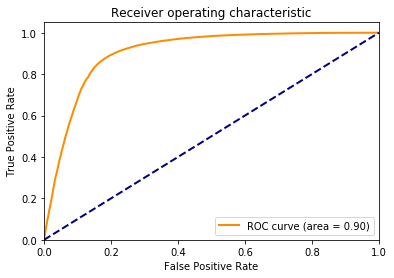

|  7        |  0.8328   |  3.589e+0 |  13.35    |  5.183    |  12.5     |  0.0099   |  12.23    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3555, acc = 0.8572, precision= 0.8884, recall = 0.8359
test:  loss 0.3569, acc = 0.8573, precision = 0.8876, recall = 0.8371
time: 0.0010094642639160156, number of hidden neurons: 56


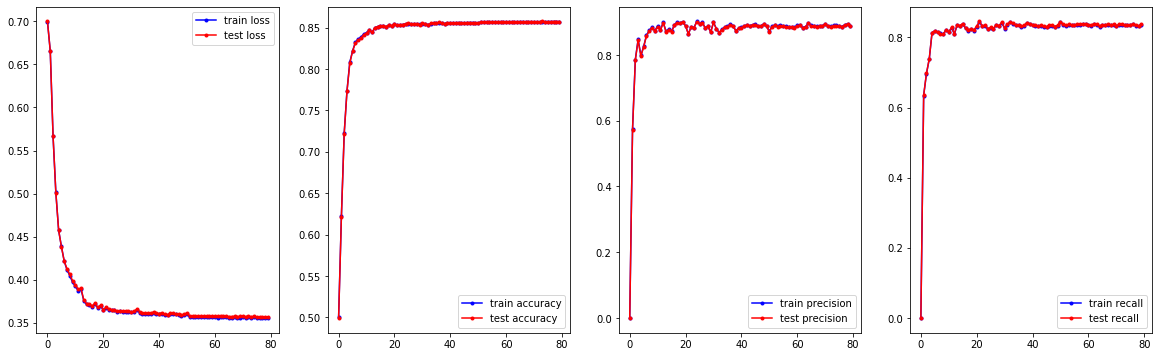

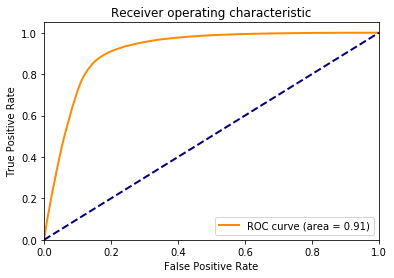

|  8        |  0.8523   |  1.762e+0 |  12.89    |  6.032    |  9.479    |  0.009177 |  7.23     |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3849, acc = 0.8458, precision= 0.8925, recall = 0.8159
test:  loss 0.3852, acc = 0.8454, precision = 0.8913, recall = 0.8166
time: 0.0009336471557617188, number of hidden neurons: 42


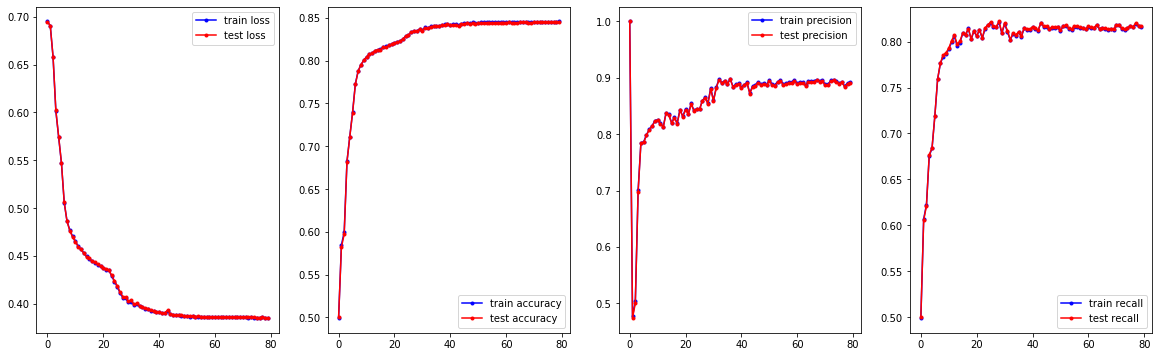

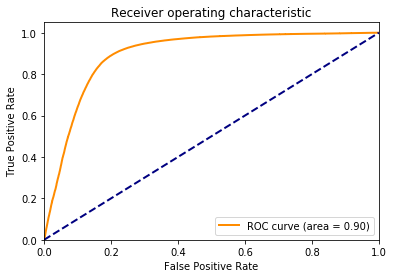

|  9        |  0.8416   |  1.795e+0 |  6.3      |  5.194    |  11.79    |  0.002905 |  6.921    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3591, acc = 0.8562, precision= 0.8915, recall = 0.8324
test:  loss 0.3606, acc = 0.8557, precision = 0.8909, recall = 0.8326
time: 0.0013034343719482422, number of hidden neurons: 132


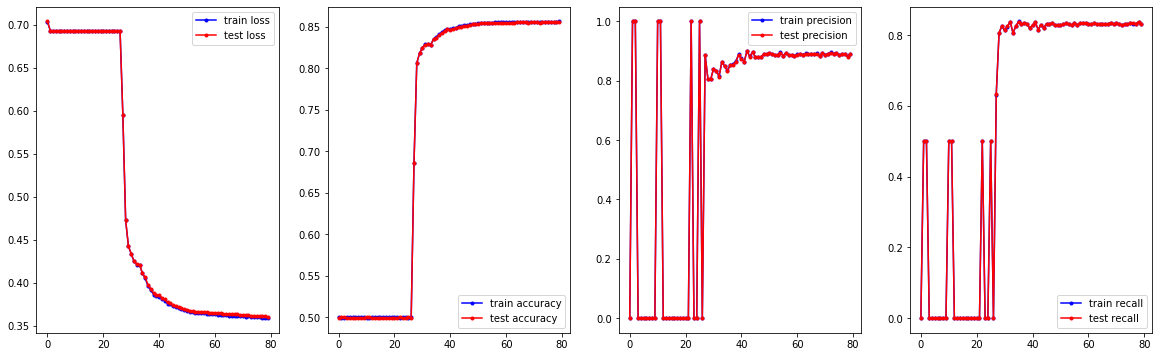

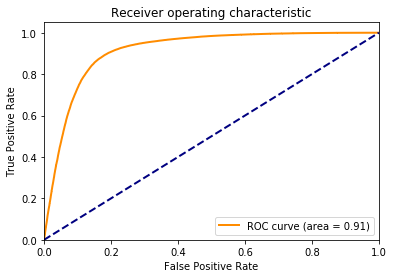

|  10       |  0.844    |  2.712e+0 |  5.534    |  10.74    |  6.467    |  0.006304 |  11.7     |


FloatProgress(value=0.0, max=80.0)

train: loss 0.4089, acc = 0.8352, precision= 0.8924, recall = 0.8005
test:  loss 0.4104, acc = 0.8344, precision = 0.8900, recall = 0.8013
time: 0.0013728141784667969, number of hidden neurons: 132


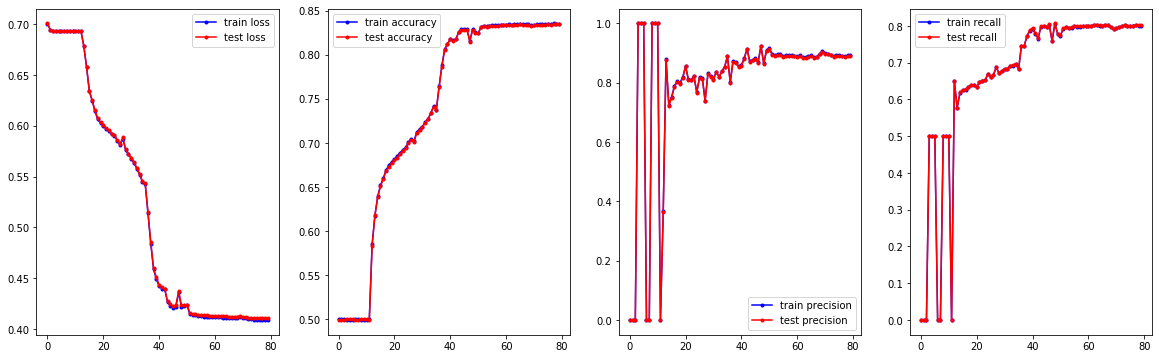

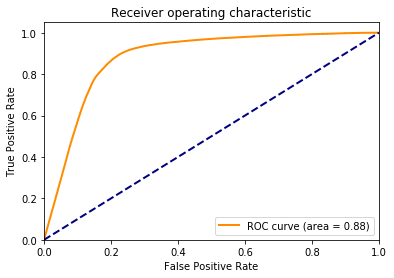

|  11       |  0.8227   |  4.999e+0 |  6.197    |  9.901    |  12.9     |  0.0021   |  11.29    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3319, acc = 0.8673, precision= 0.8963, recall = 0.8469
test:  loss 0.3340, acc = 0.8668, precision = 0.8950, recall = 0.8475
time: 0.0009009838104248047, number of hidden neurons: 42


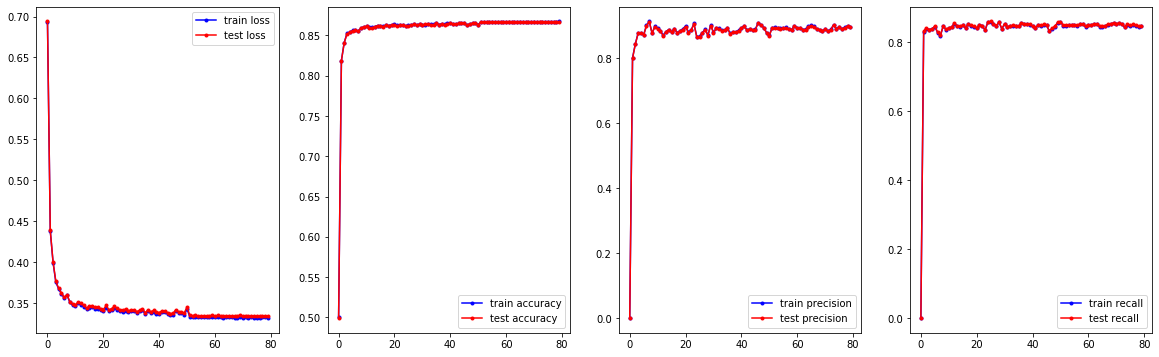

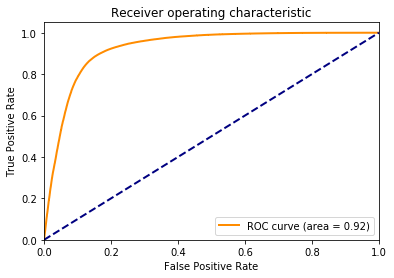

|  12       |  0.863    |  5.003e+0 |  13.83    |  13.95    |  14.06    |  0.008198 |  6.829    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3478, acc = 0.8606, precision= 0.8919, recall = 0.8391
test:  loss 0.3488, acc = 0.8603, precision = 0.8909, recall = 0.8399
time: 0.0008645057678222656, number of hidden neurons: 30


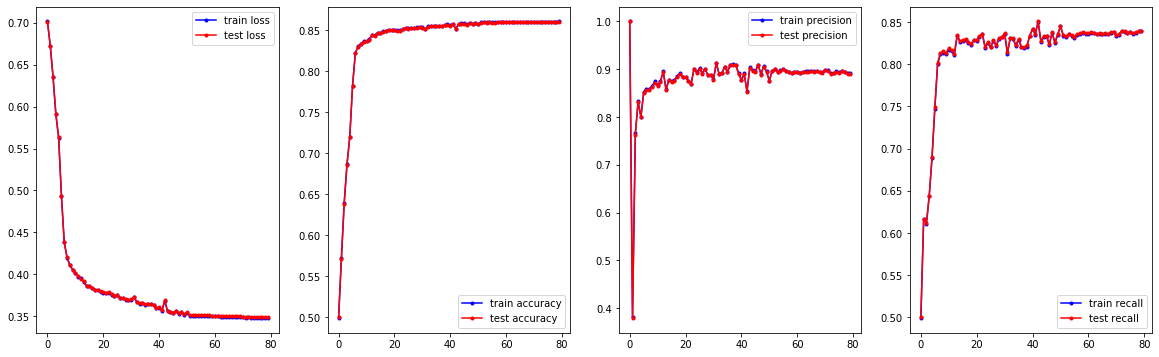

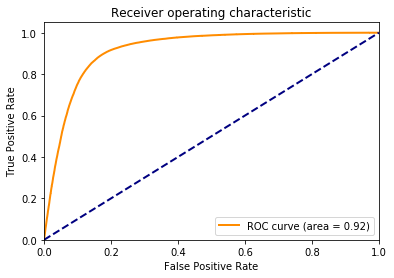

|  13       |  0.8577   |  4e+04    |  13.91    |  13.54    |  9.277    |  0.006018 |  5.937    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3404, acc = 0.8637, precision= 0.8943, recall = 0.8424
test:  loss 0.3419, acc = 0.8635, precision = 0.8927, recall = 0.8438
time: 0.0013394355773925781, number of hidden neurons: 110


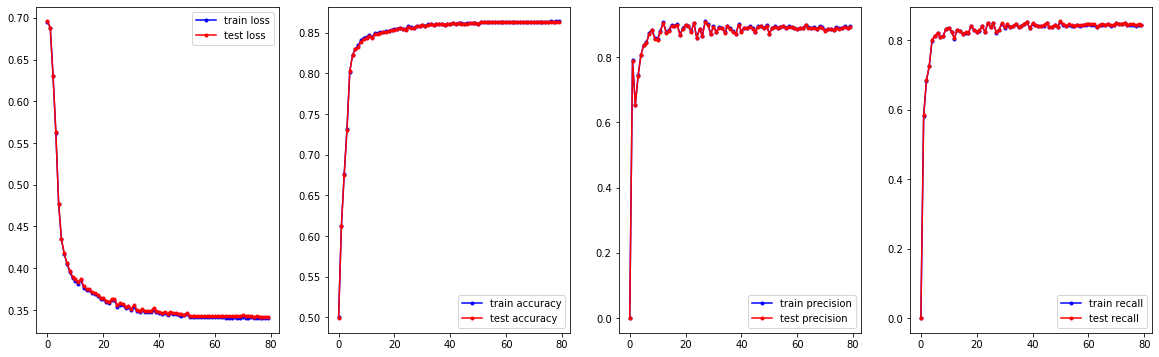

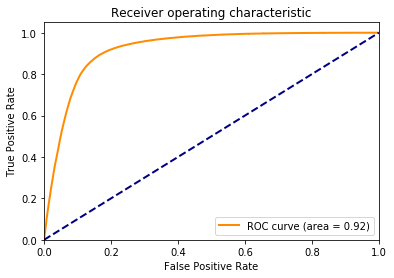

|  14       |  0.8537   |  3.154e+0 |  14.55    |  13.63    |  7.662    |  0.005968 |  10.27    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3317, acc = 0.8668, precision= 0.8930, recall = 0.8482
test:  loss 0.3339, acc = 0.8669, precision = 0.8926, recall = 0.8493
time: 0.0014047622680664062, number of hidden neurons: 156


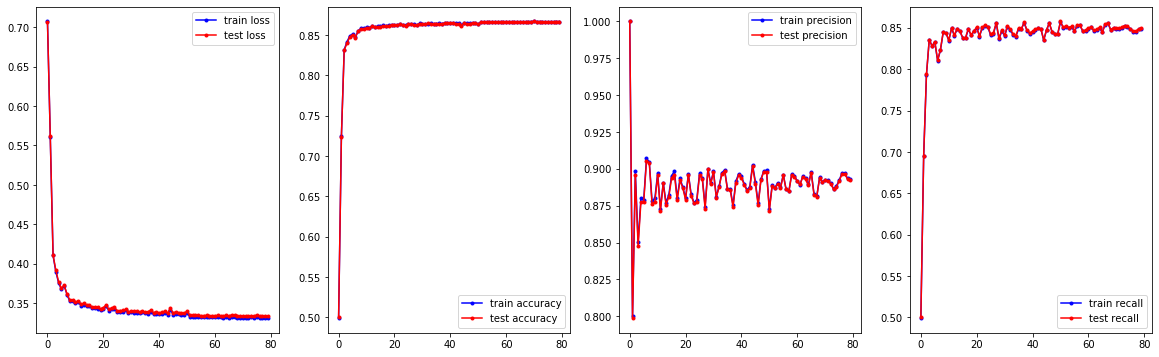

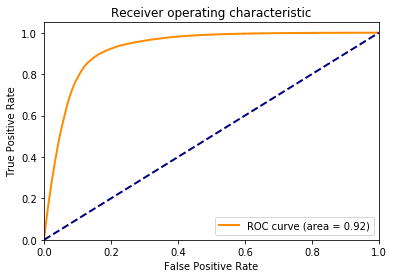

|  15       |  0.8531   |  6.862e+0 |  13.78    |  13.81    |  6.168    |  0.006599 |  12.15    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3440, acc = 0.8624, precision= 0.8918, recall = 0.8420
test:  loss 0.3454, acc = 0.8622, precision = 0.8906, recall = 0.8431
time: 0.0012521743774414062, number of hidden neurons: 110


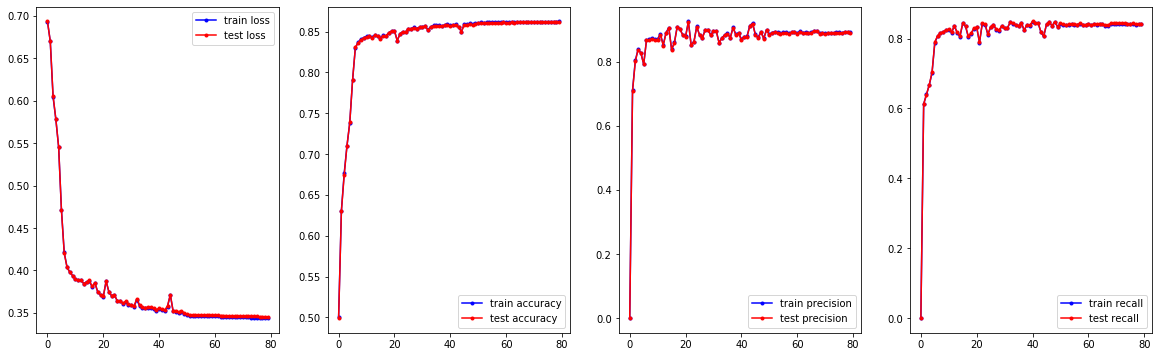

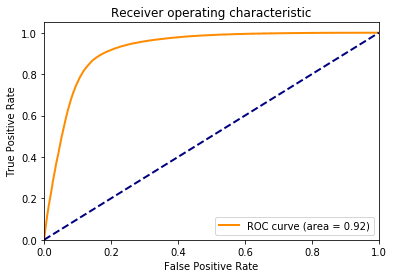

|  16       |  0.8524   |  4.764e+0 |  13.23    |  14.79    |  11.12    |  0.009308 |  10.2     |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3481, acc = 0.8603, precision= 0.8857, recall = 0.8426
test:  loss 0.3496, acc = 0.8599, precision = 0.8843, recall = 0.8434
time: 0.0010991096496582031, number of hidden neurons: 72


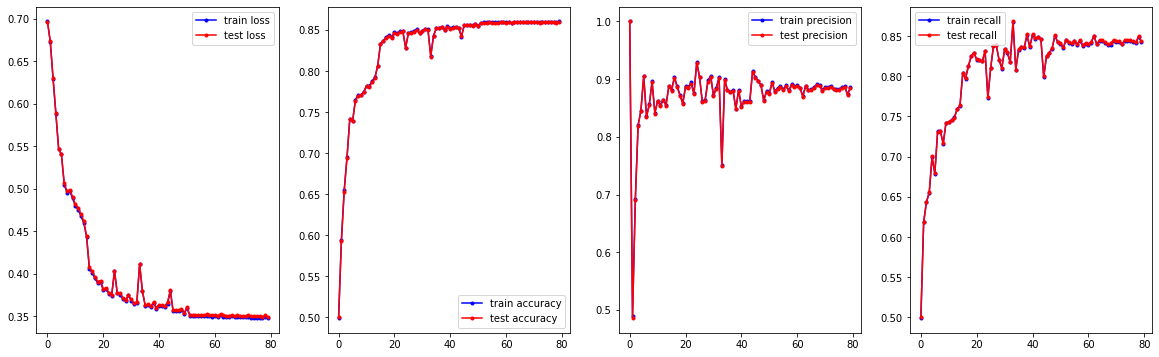

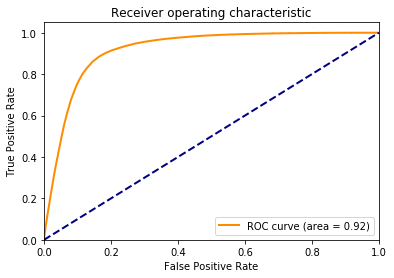

|  17       |  0.8535   |  2.959e+0 |  14.92    |  8.331    |  6.774    |  0.008538 |  8.948    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3393, acc = 0.8645, precision= 0.8918, recall = 0.8454
test:  loss 0.3410, acc = 0.8646, precision = 0.8910, recall = 0.8466
time: 0.0010993480682373047, number of hidden neurons: 72


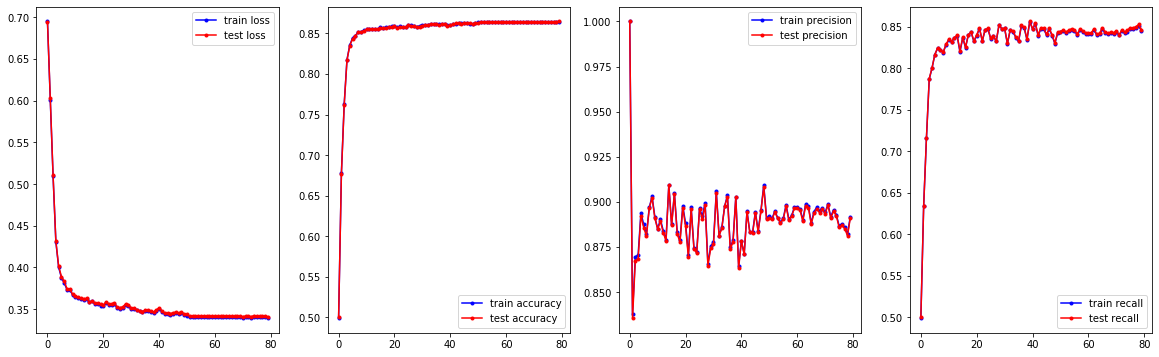

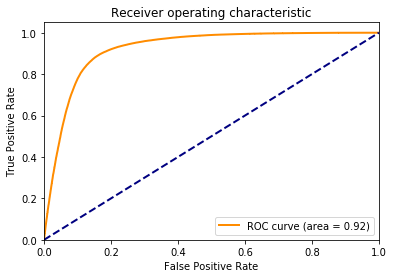

|  18       |  0.8582   |  1.132e+0 |  8.572    |  13.12    |  13.98    |  0.003805 |  8.119    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3505, acc = 0.8598, precision= 0.8953, recall = 0.8357
test:  loss 0.3521, acc = 0.8594, precision = 0.8942, recall = 0.8363
time: 0.0008442401885986328, number of hidden neurons: 30


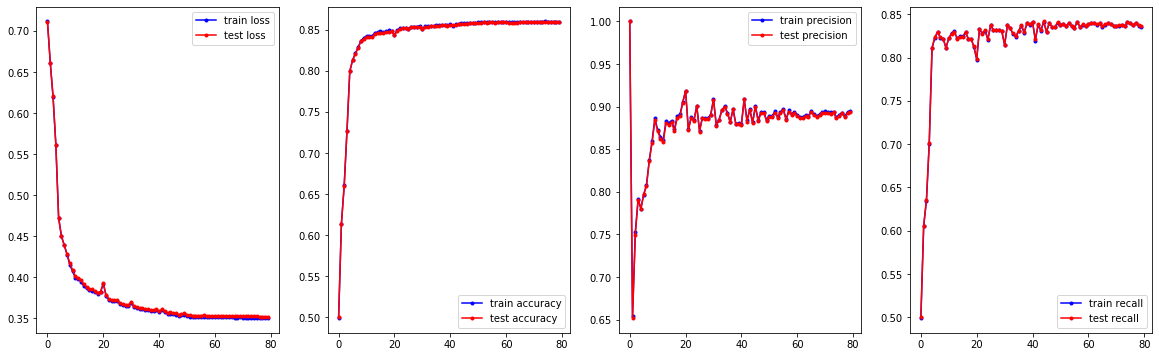

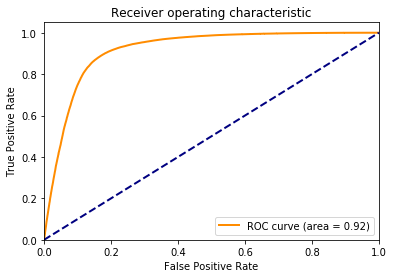

|  19       |  0.8567   |  3.829e+0 |  12.43    |  8.471    |  5.594    |  0.009159 |  5.79     |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3459, acc = 0.8613, precision= 0.8946, recall = 0.8384
test:  loss 0.3472, acc = 0.8613, precision = 0.8936, recall = 0.8397
time: 0.0008533000946044922, number of hidden neurons: 30


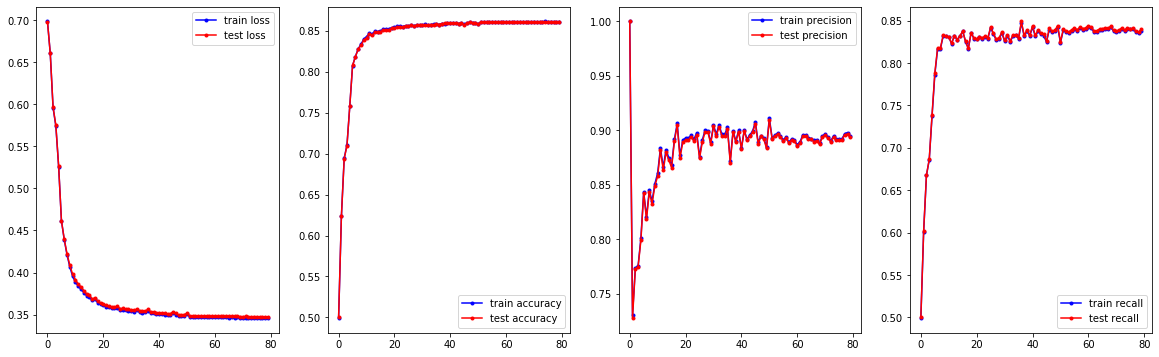

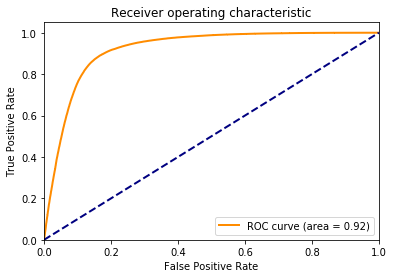

|  20       |  0.8586   |  2.516e+0 |  14.18    |  9.733    |  5.021    |  0.005066 |  5.373    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3431, acc = 0.8624, precision= 0.8940, recall = 0.8405
test:  loss 0.3444, acc = 0.8623, precision = 0.8939, recall = 0.8410
time: 0.0007693767547607422, number of hidden neurons: 20


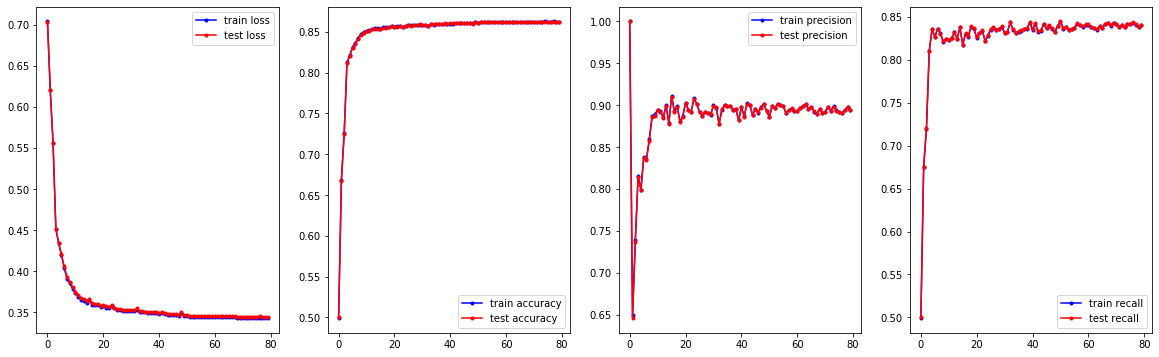

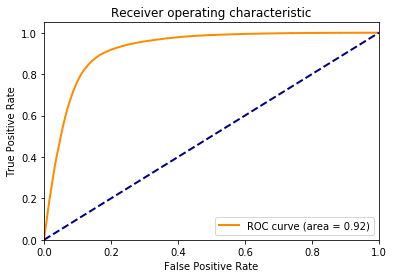

|  21       |  0.8605   |  1.649e+0 |  10.0     |  14.81    |  5.411    |  0.004468 |  4.277    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3375, acc = 0.8659, precision= 0.8898, recall = 0.8489
test:  loss 0.3400, acc = 0.8653, precision = 0.8879, recall = 0.8498
time: 0.000942230224609375, number of hidden neurons: 42


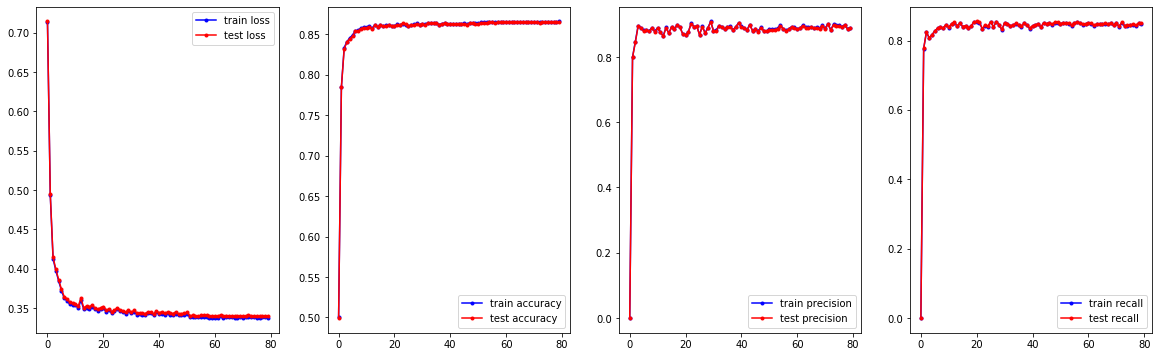

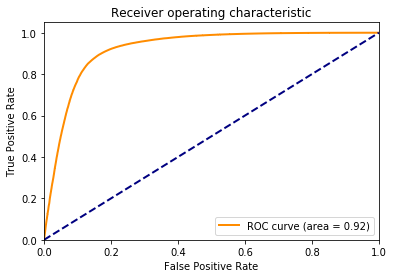

|  22       |  0.8616   |  8.457e+0 |  14.93    |  7.709    |  5.348    |  0.009644 |  6.819    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3438, acc = 0.8622, precision= 0.8876, recall = 0.8444
test:  loss 0.3452, acc = 0.8619, precision = 0.8869, recall = 0.8450
time: 0.001504659652709961, number of hidden neurons: 182


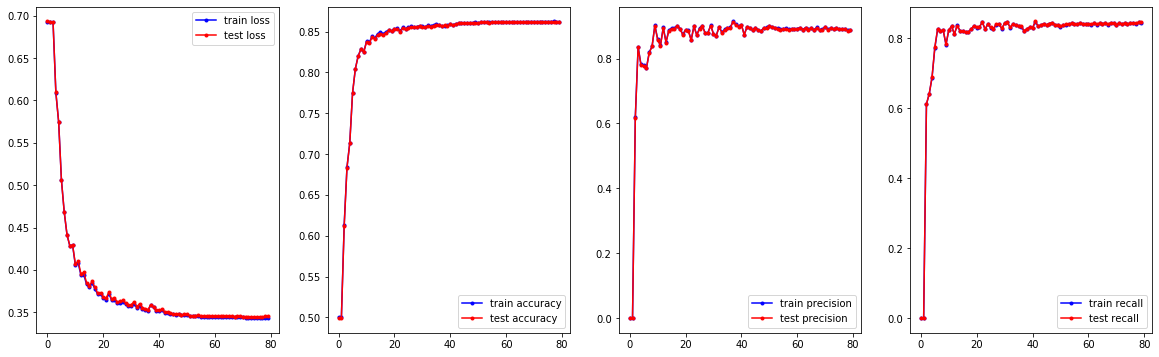

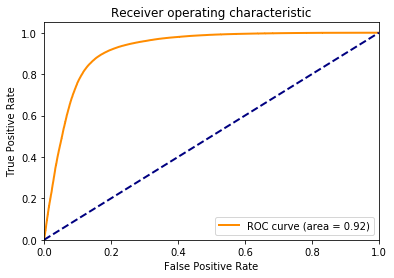

|  23       |  0.8457   |  3.918e+0 |  13.85    |  12.4     |  14.97    |  0.007435 |  13.88    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3515, acc = 0.8597, precision= 0.8931, recall = 0.8368
test:  loss 0.3530, acc = 0.8589, precision = 0.8918, recall = 0.8370
time: 0.0010211467742919922, number of hidden neurons: 56


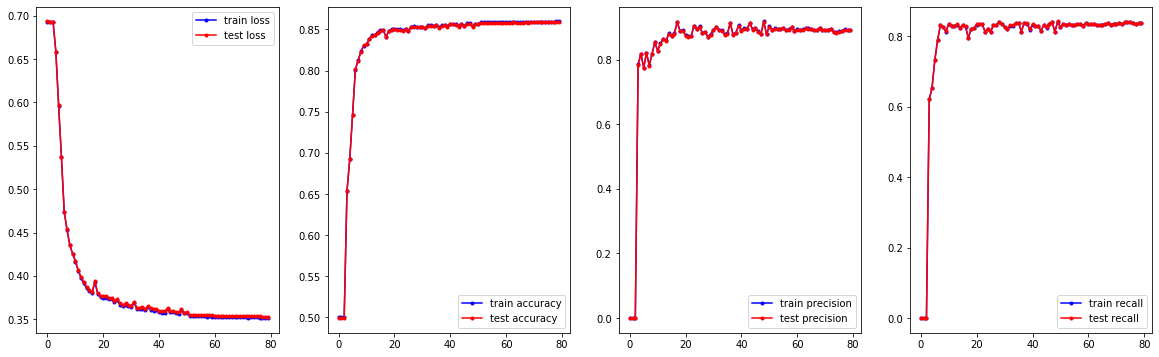

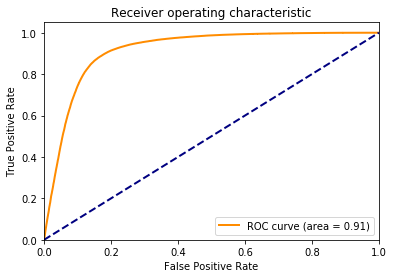

|  24       |  0.8539   |  4.192e+0 |  5.719    |  13.77    |  5.926    |  0.007024 |  8.0      |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3669, acc = 0.8524, precision= 0.8939, recall = 0.8252
test:  loss 0.3678, acc = 0.8523, precision = 0.8933, recall = 0.8260
time: 0.0007824897766113281, number of hidden neurons: 20


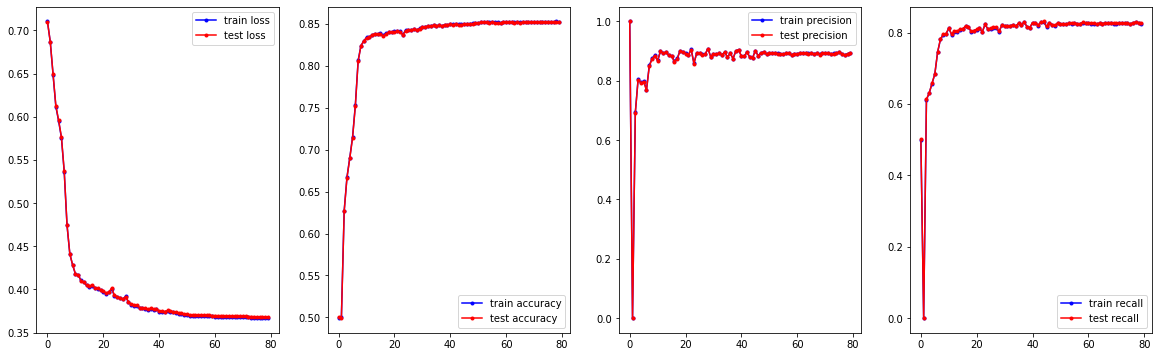

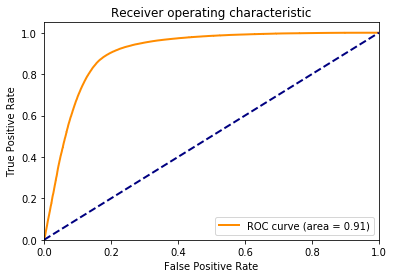

|  25       |  0.8505   |  4.094e+0 |  11.14    |  6.9      |  5.665    |  0.006866 |  4.703    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3559, acc = 0.8566, precision= 0.9010, recall = 0.8273
test:  loss 0.3574, acc = 0.8562, precision = 0.8996, recall = 0.8281
time: 0.0009987354278564453, number of hidden neurons: 42


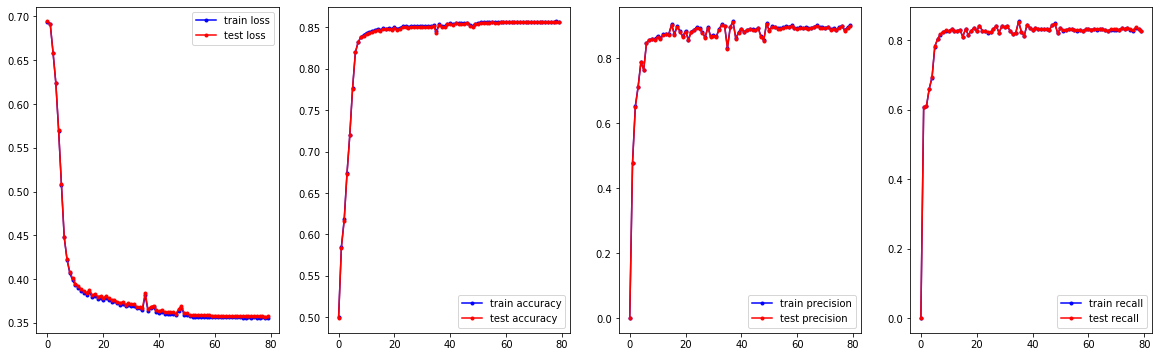

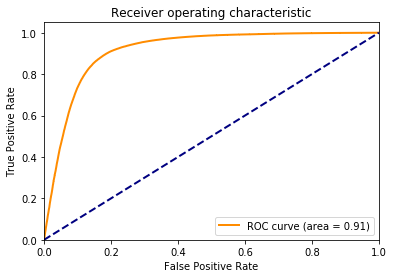

|  26       |  0.8525   |  3.325e+0 |  5.52     |  10.41    |  5.264    |  0.004581 |  6.339    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3711, acc = 0.8535, precision= 0.8803, recall = 0.8353
test:  loss 0.3719, acc = 0.8532, precision = 0.8790, recall = 0.8362
time: 0.0008509159088134766, number of hidden neurons: 30


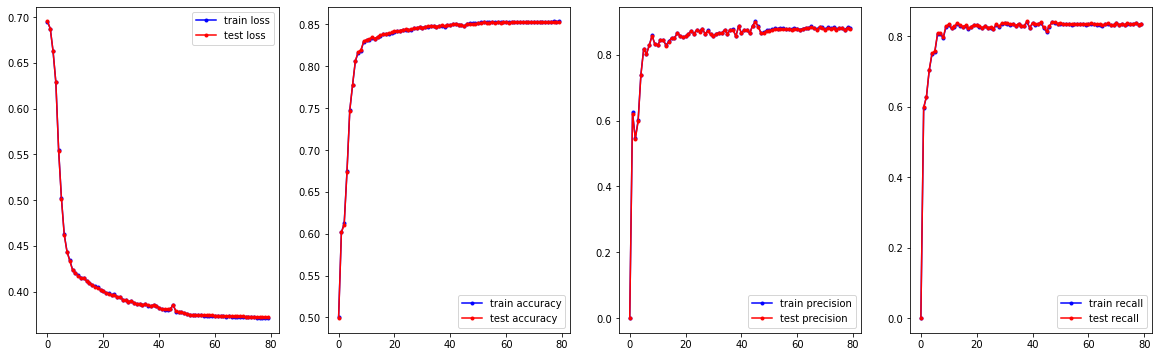

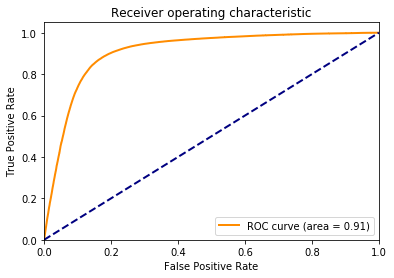

|  27       |  0.8505   |  4.871e+0 |  6.506    |  14.48    |  8.504    |  0.006051 |  5.025    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3727, acc = 0.8511, precision= 0.8803, recall = 0.8313
test:  loss 0.3747, acc = 0.8499, precision = 0.8785, recall = 0.8313
time: 0.0008609294891357422, number of hidden neurons: 30


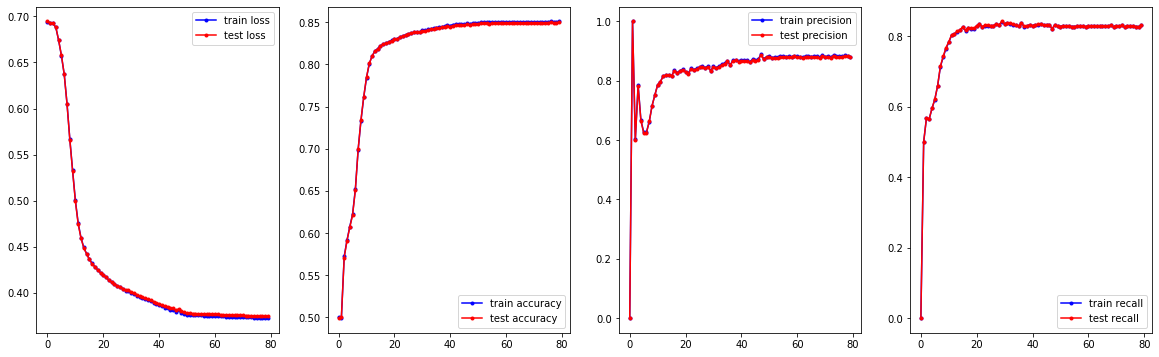

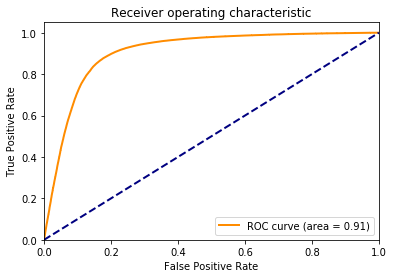

|  28       |  0.8472   |  3.726e+0 |  5.551    |  13.04    |  12.7     |  0.00128  |  5.002    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3448, acc = 0.8617, precision= 0.8929, recall = 0.8401
test:  loss 0.3464, acc = 0.8614, precision = 0.8919, recall = 0.8409
time: 0.0007848739624023438, number of hidden neurons: 20


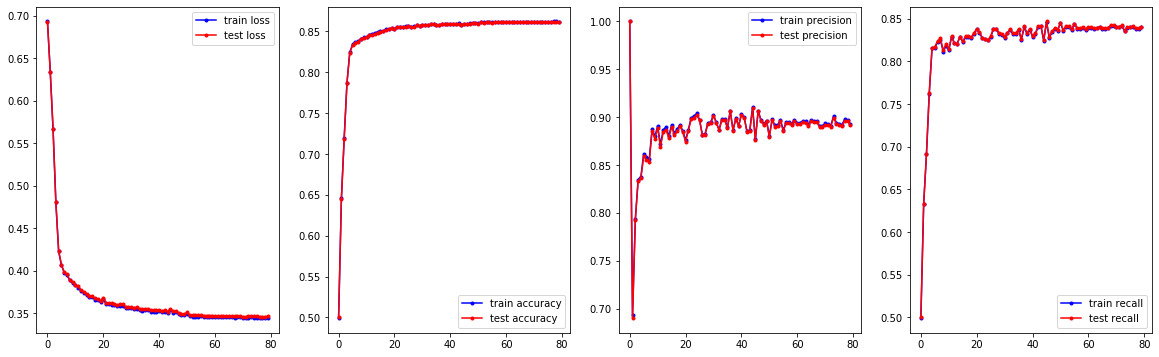

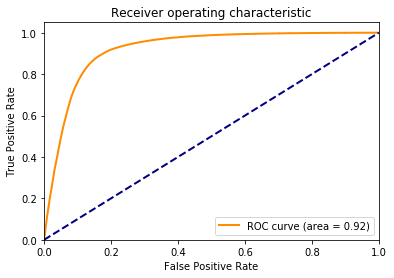

|  29       |  0.8596   |  2.139e+0 |  14.71    |  13.88    |  6.808    |  0.005574 |  4.678    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3460, acc = 0.8619, precision= 0.8960, recall = 0.8385
test:  loss 0.3476, acc = 0.8613, precision = 0.8946, recall = 0.8390
time: 0.0008533000946044922, number of hidden neurons: 30


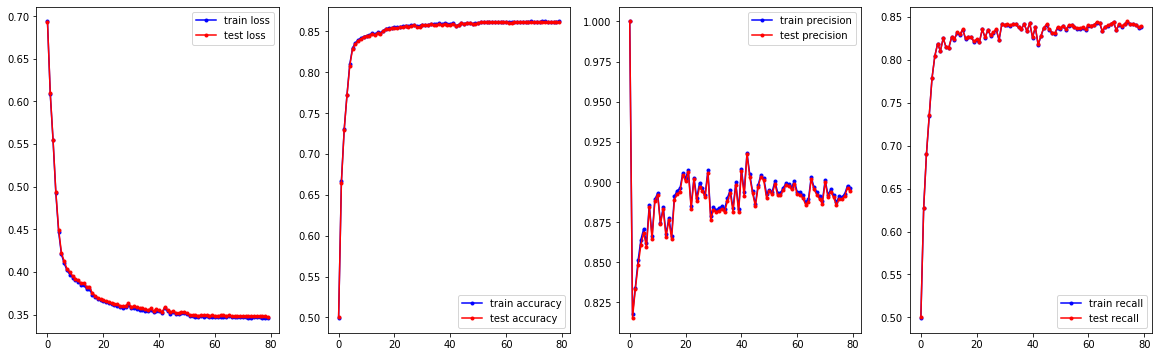

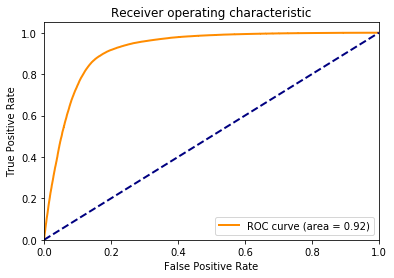

|  30       |  0.8586   |  2.222e+0 |  12.64    |  10.44    |  6.307    |  0.008916 |  5.862    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3611, acc = 0.8543, precision= 0.8880, recall = 0.8315
test:  loss 0.3619, acc = 0.8540, precision = 0.8877, recall = 0.8320
time: 0.0008721351623535156, number of hidden neurons: 30


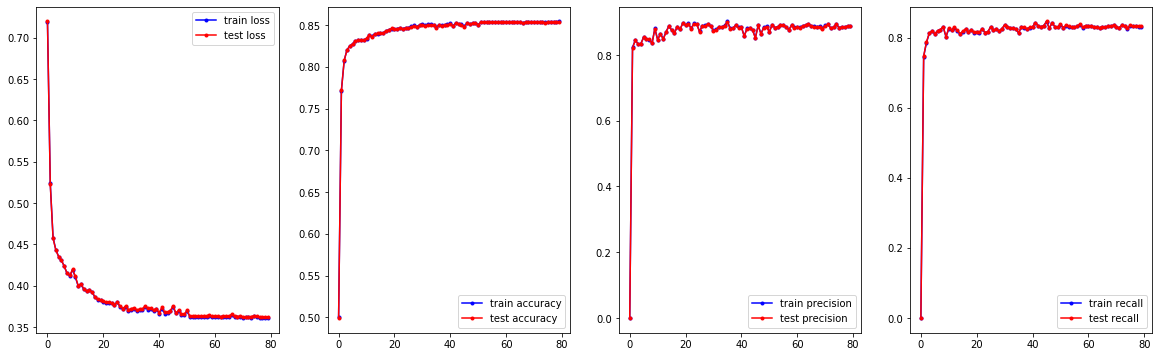

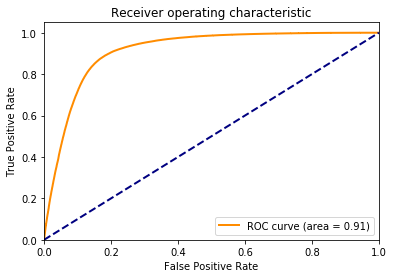

|  31       |  0.8514   |  5.671e+0 |  14.21    |  5.828    |  6.759    |  0.003808 |  5.551    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3511, acc = 0.8598, precision= 0.8825, recall = 0.8439
test:  loss 0.3525, acc = 0.8591, precision = 0.8809, recall = 0.8444
time: 0.0007822513580322266, number of hidden neurons: 20


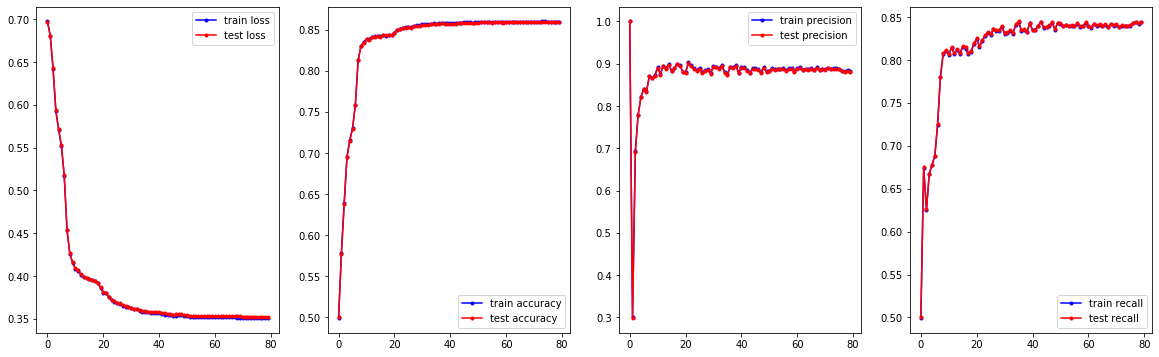

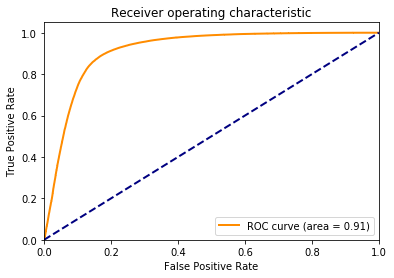

|  32       |  0.8573   |  3.049e+0 |  5.349    |  14.84    |  5.418    |  0.003876 |  4.381    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3495, acc = 0.8594, precision= 0.8951, recall = 0.8352
test:  loss 0.3509, acc = 0.8592, precision = 0.8942, recall = 0.8360
time: 0.0008685588836669922, number of hidden neurons: 30


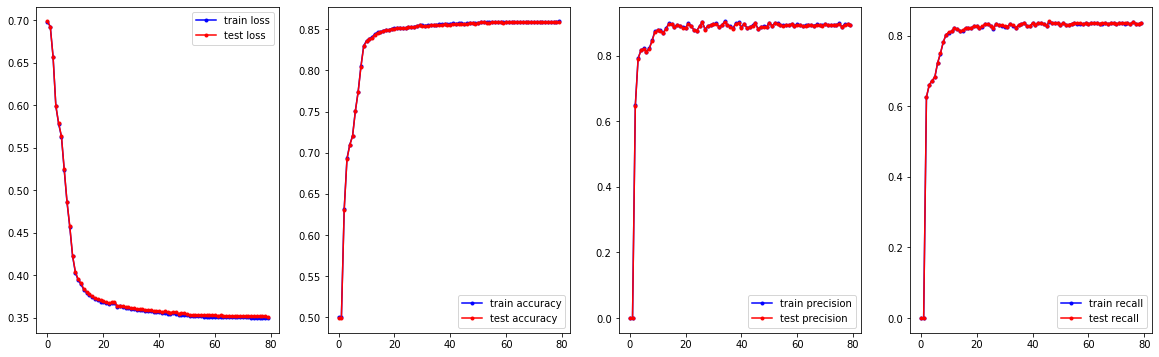

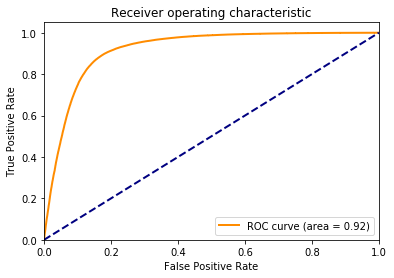

|  33       |  0.8565   |  1.225e+0 |  14.14    |  10.74    |  5.082    |  0.001213 |  5.675    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3414, acc = 0.8625, precision= 0.8959, recall = 0.8396
test:  loss 0.3430, acc = 0.8618, precision = 0.8948, recall = 0.8397
time: 0.0007803440093994141, number of hidden neurons: 20


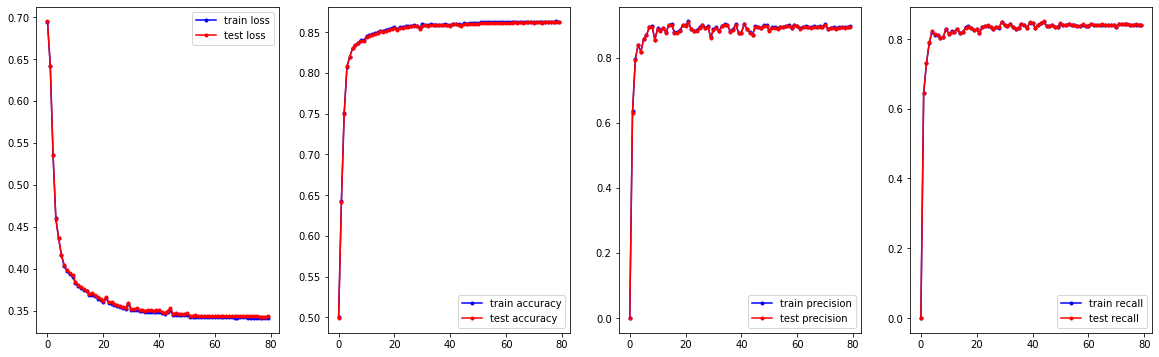

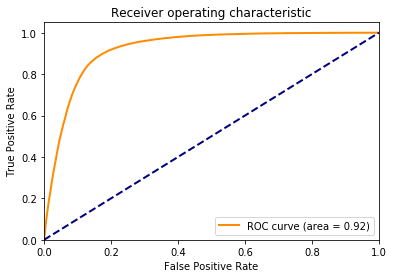

|  34       |  0.86     |  2.589e+0 |  14.84    |  12.76    |  8.851    |  0.007529 |  4.412    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3549, acc = 0.8579, precision= 0.8939, recall = 0.8335
test:  loss 0.3561, acc = 0.8574, precision = 0.8929, recall = 0.8340
time: 0.0008733272552490234, number of hidden neurons: 30


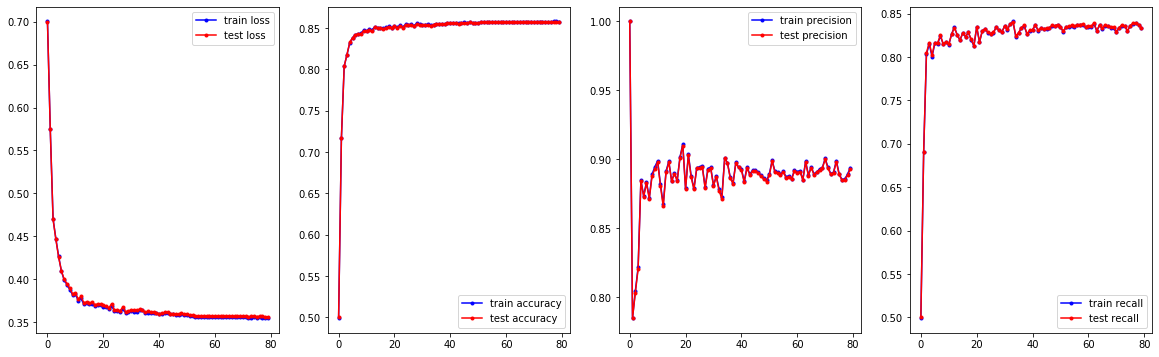

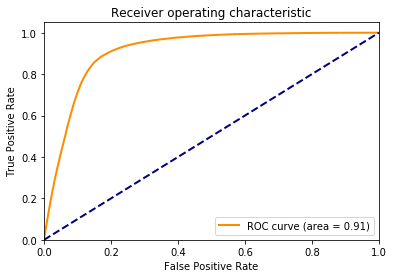

|  35       |  0.8547   |  1.021e+0 |  14.72    |  5.239    |  9.145    |  0.008238 |  5.615    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3612, acc = 0.8562, precision= 0.8995, recall = 0.8275
test:  loss 0.3631, acc = 0.8555, precision = 0.8985, recall = 0.8276
time: 0.0007612705230712891, number of hidden neurons: 20


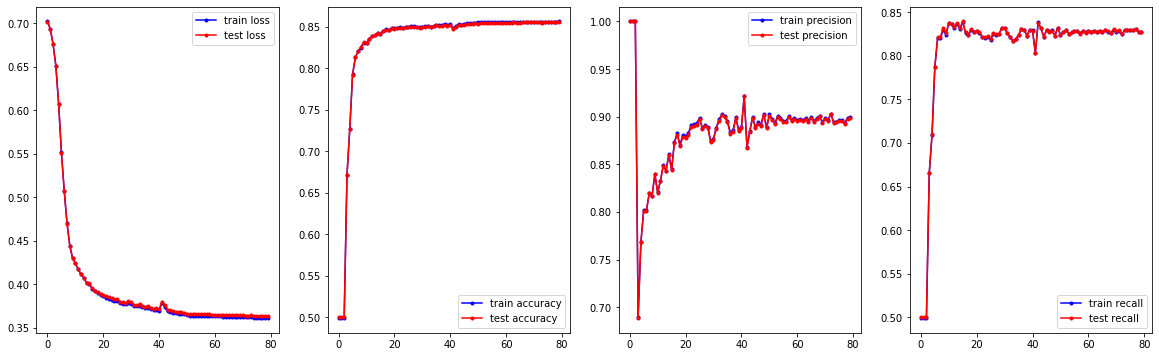

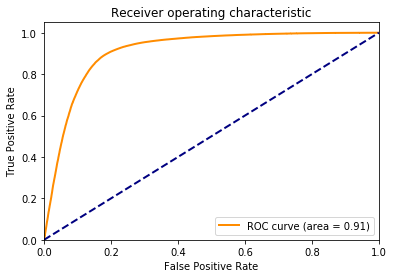

|  36       |  0.8537   |  4.279e+0 |  14.34    |  14.47    |  5.22     |  0.004949 |  4.275    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3430, acc = 0.8624, precision= 0.8930, recall = 0.8412
test:  loss 0.3445, acc = 0.8617, precision = 0.8909, recall = 0.8420
time: 0.0008420944213867188, number of hidden neurons: 30


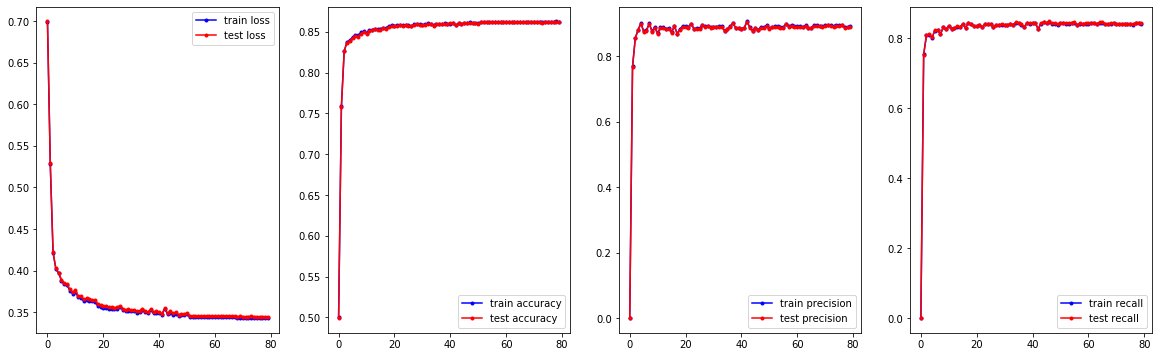

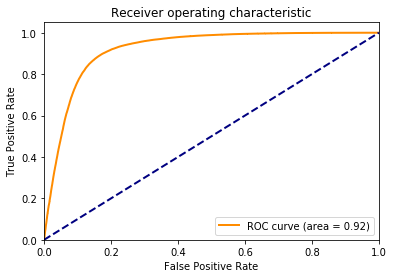

|  37       |  0.859    |  7.802e+0 |  6.276    |  14.59    |  12.05    |  0.004053 |  5.361    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3364, acc = 0.8651, precision= 0.8927, recall = 0.8458
test:  loss 0.3378, acc = 0.8650, precision = 0.8917, recall = 0.8468
time: 0.0007753372192382812, number of hidden neurons: 20


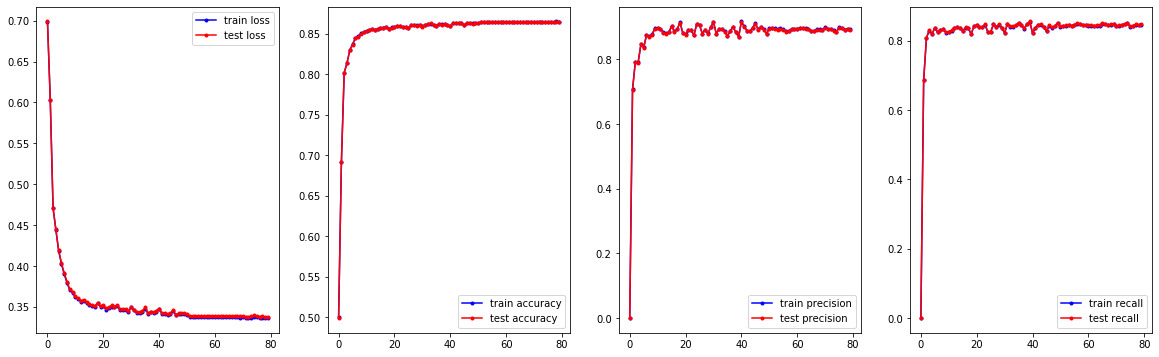

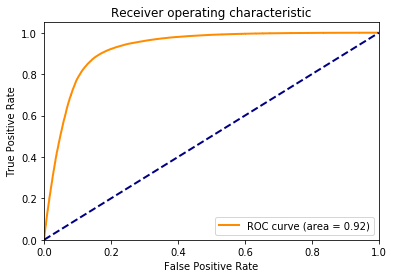

|  38       |  0.8632   |  1.688e+0 |  14.86    |  12.15    |  13.12    |  0.007042 |  4.264    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3404, acc = 0.8636, precision= 0.8975, recall = 0.8403
test:  loss 0.3416, acc = 0.8633, precision = 0.8960, recall = 0.8413
time: 0.0013842582702636719, number of hidden neurons: 156


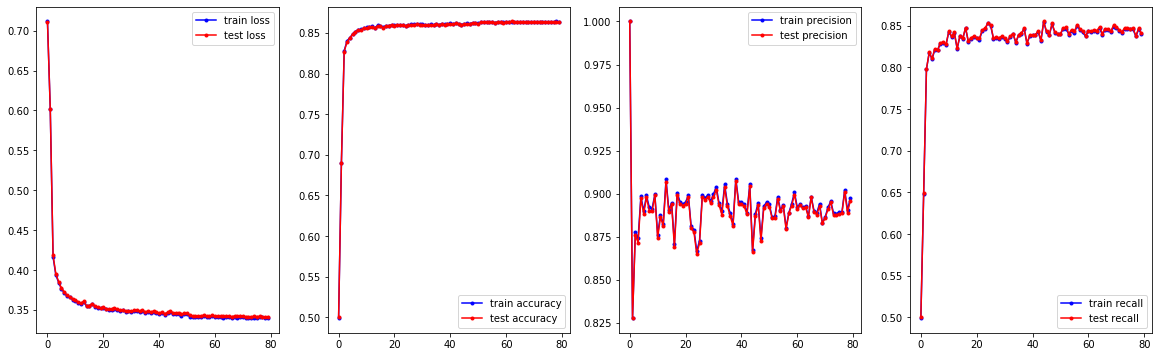

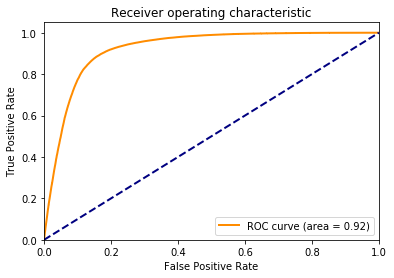

|  39       |  0.8494   |  5.007e+0 |  6.108    |  14.68    |  5.535    |  0.003758 |  12.88    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3446, acc = 0.8618, precision= 0.8857, recall = 0.8450
test:  loss 0.3464, acc = 0.8615, precision = 0.8843, recall = 0.8461
time: 0.0009479522705078125, number of hidden neurons: 42


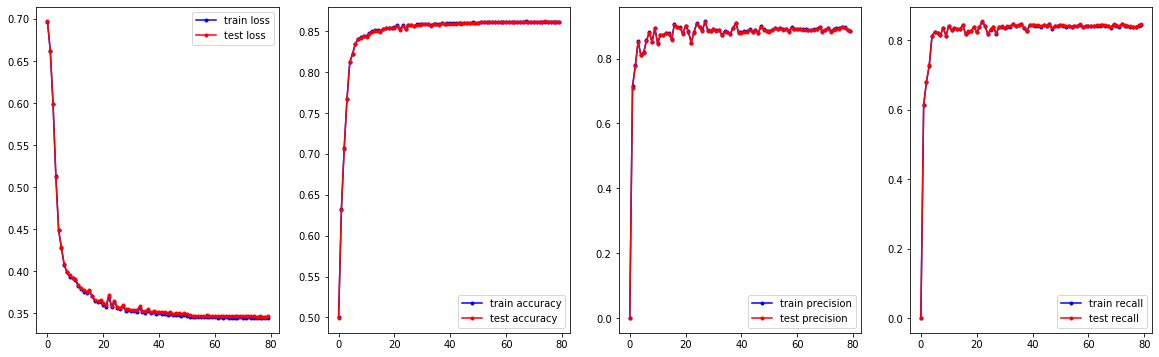

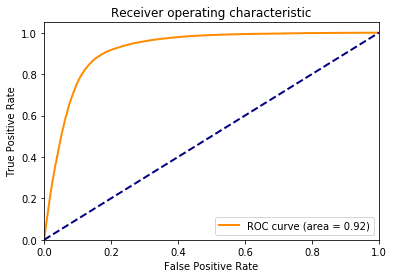

|  40       |  0.8578   |  3.434e+0 |  13.7     |  12.13    |  7.336    |  0.008442 |  6.759    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3653, acc = 0.8521, precision= 0.8913, recall = 0.8261
test:  loss 0.3681, acc = 0.8510, precision = 0.8891, recall = 0.8264
time: 0.0010027885437011719, number of hidden neurons: 56


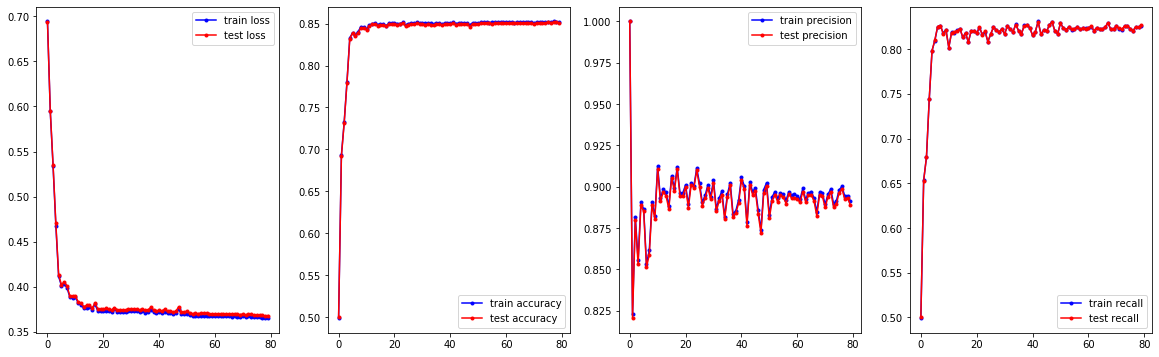

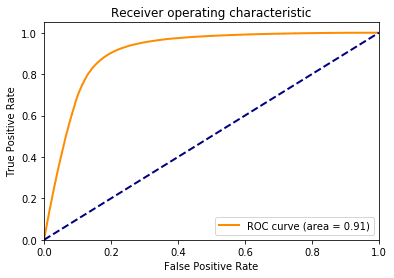

|  41       |  0.846    |  8.84e+03 |  13.35    |  6.934    |  14.78    |  0.003713 |  7.993    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3925, acc = 0.8452, precision= 0.8838, recall = 0.8201
test:  loss 0.3943, acc = 0.8437, precision = 0.8808, recall = 0.8203
time: 0.0008504390716552734, number of hidden neurons: 30


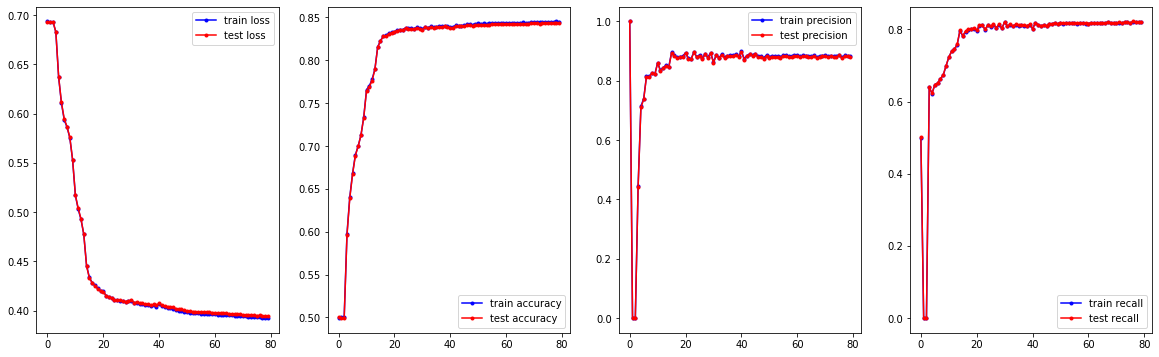

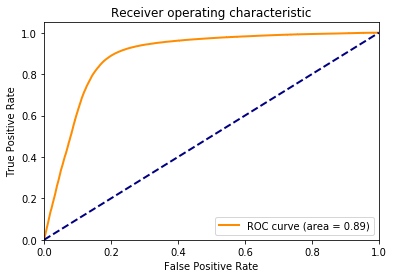

|  42       |  0.8411   |  4.616e+0 |  7.165    |  5.136    |  5.149    |  0.004542 |  5.442    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3373, acc = 0.8653, precision= 0.8881, recall = 0.8491
test:  loss 0.3395, acc = 0.8646, precision = 0.8868, recall = 0.8494
time: 0.000820159912109375, number of hidden neurons: 30


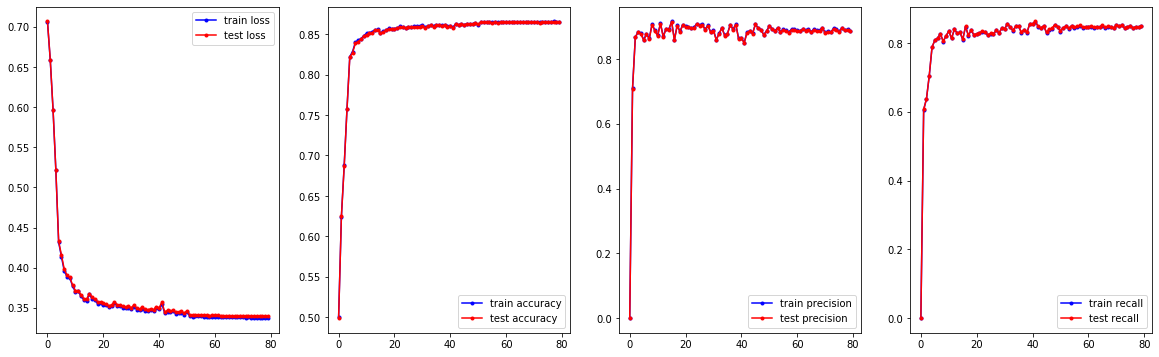

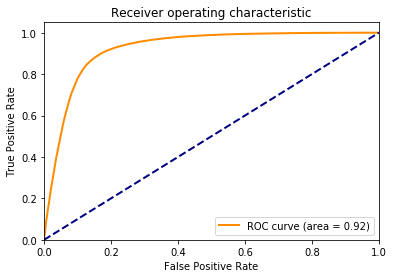

|  43       |  0.8619   |  1.993e+0 |  14.08    |  14.42    |  5.558    |  0.009989 |  5.751    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3389, acc = 0.8641, precision= 0.8923, recall = 0.8444
test:  loss 0.3410, acc = 0.8637, precision = 0.8913, recall = 0.8450
time: 0.0007691383361816406, number of hidden neurons: 20


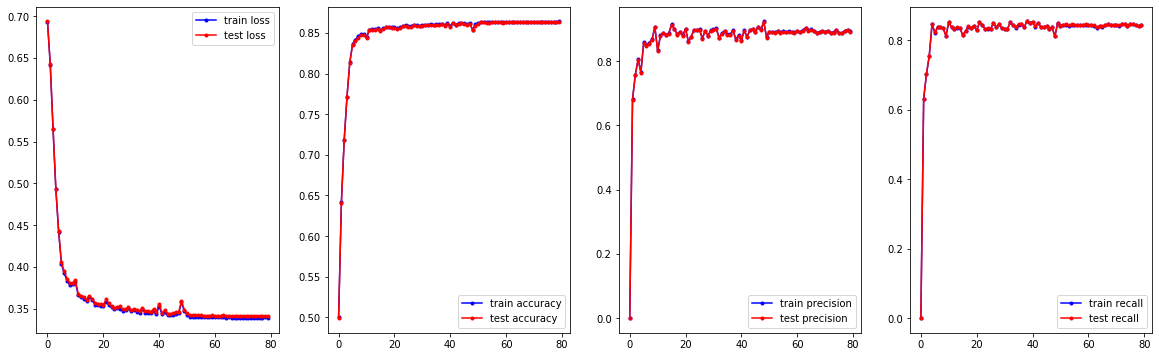

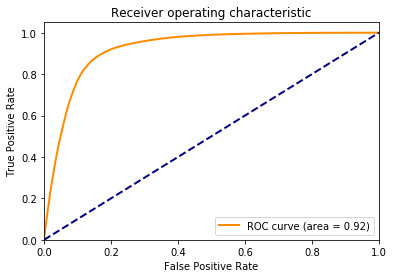

|  44       |  0.8619   |  2.836e+0 |  14.24    |  14.43    |  8.367    |  0.007047 |  4.192    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3527, acc = 0.8583, precision= 0.8970, recall = 0.8323
test:  loss 0.3534, acc = 0.8582, precision = 0.8964, recall = 0.8331
time: 0.0007774829864501953, number of hidden neurons: 20


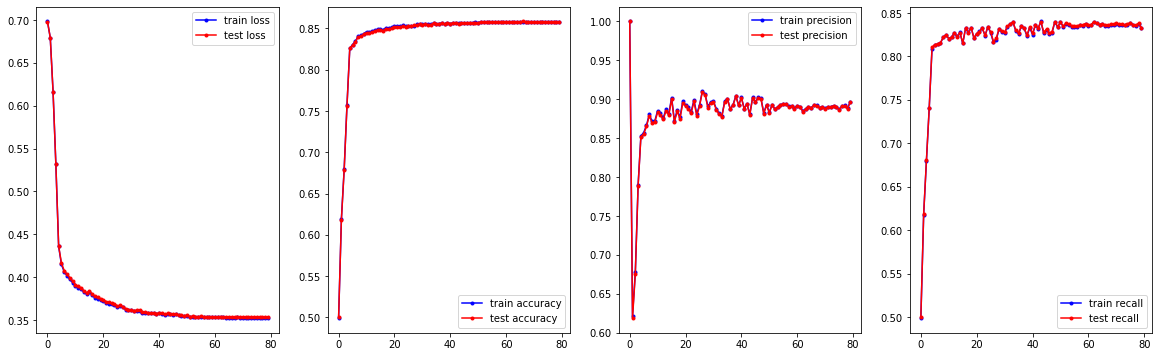

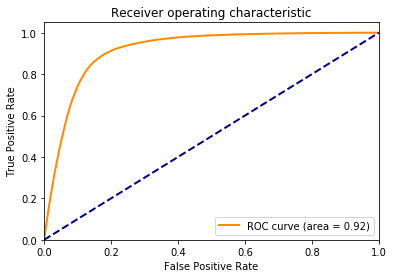

|  45       |  0.8564   |  2.056e+0 |  5.261    |  11.72    |  7.057    |  0.004103 |  4.002    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3356, acc = 0.8652, precision= 0.8925, recall = 0.8461
test:  loss 0.3376, acc = 0.8650, precision = 0.8911, recall = 0.8472
time: 0.0007717609405517578, number of hidden neurons: 20


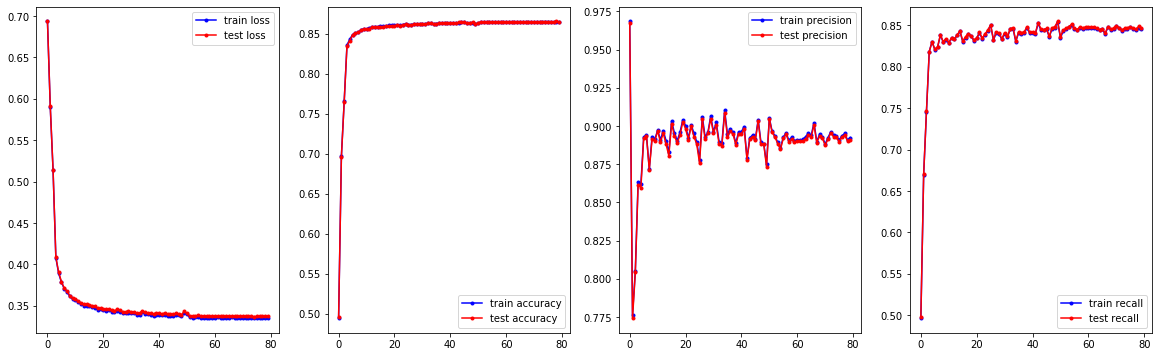

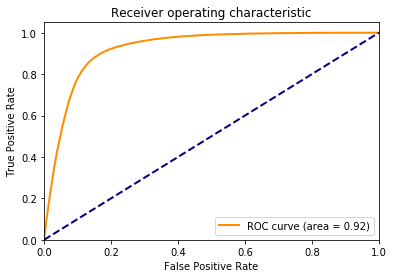

|  46       |  0.8632   |  1.548e+0 |  14.99    |  14.33    |  9.282    |  0.005048 |  4.644    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3497, acc = 0.8590, precision= 0.8989, recall = 0.8322
test:  loss 0.3509, acc = 0.8588, precision = 0.8978, recall = 0.8332
time: 0.0008459091186523438, number of hidden neurons: 30


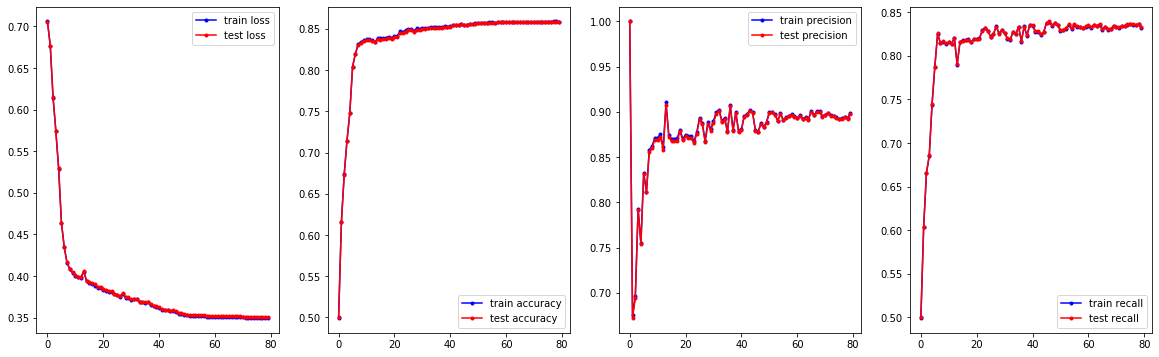

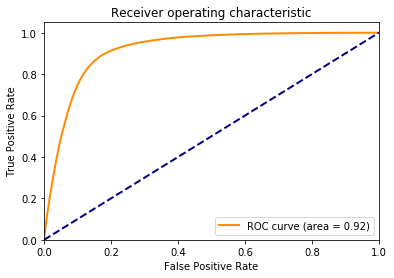

|  47       |  0.8562   |  3.233e+0 |  7.346    |  14.5     |  5.553    |  0.00628  |  5.575    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3385, acc = 0.8648, precision= 0.8916, recall = 0.8459
test:  loss 0.3400, acc = 0.8645, precision = 0.8912, recall = 0.8464
time: 0.0010766983032226562, number of hidden neurons: 72


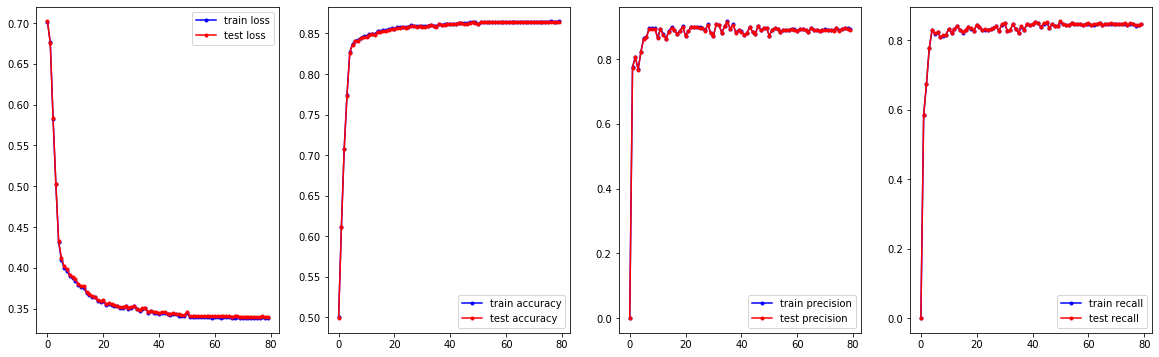

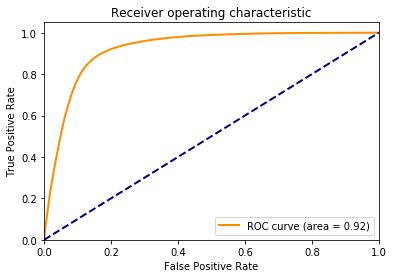

|  48       |  0.8581   |  1.925e+0 |  13.89    |  14.3     |  8.617    |  0.004622 |  8.553    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3708, acc = 0.8533, precision= 0.8918, recall = 0.8278
test:  loss 0.3723, acc = 0.8529, precision = 0.8921, recall = 0.8276
time: 0.0014801025390625, number of hidden neurons: 182


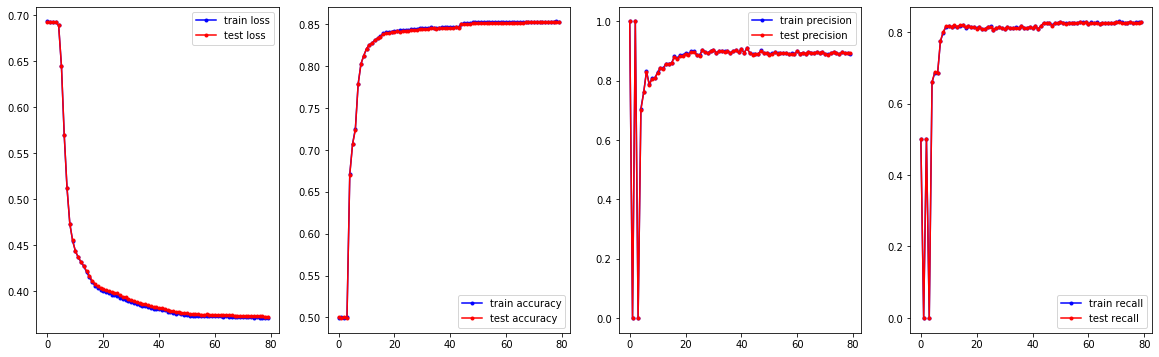

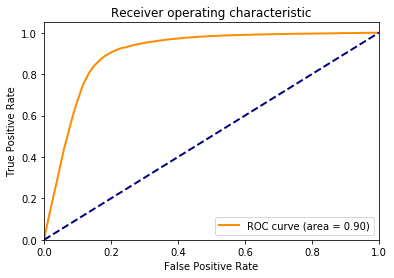

|  49       |  0.8368   |  2.889e+0 |  5.049    |  13.78    |  7.215    |  0.001431 |  13.01    |


FloatProgress(value=0.0, max=80.0)

train: loss 0.3660, acc = 0.8529, precision= 0.8821, recall = 0.8331
test:  loss 0.3681, acc = 0.8527, precision = 0.8813, recall = 0.8339
time: 0.0011756420135498047, number of hidden neurons: 90


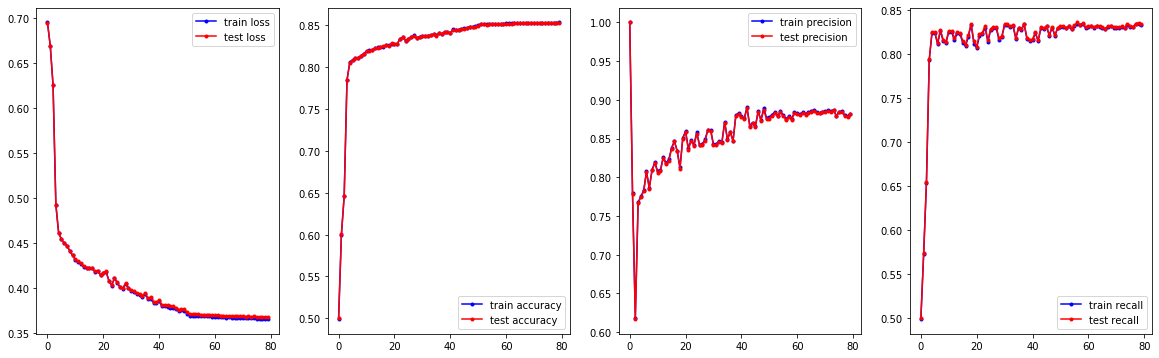

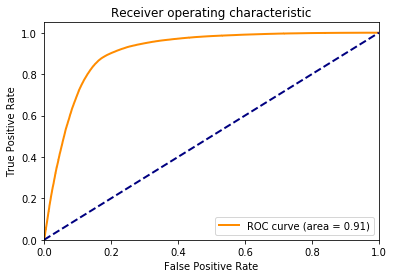

|  50       |  0.8447   |  2.78e+04 |  14.47    |  5.009    |  14.16    |  0.00742  |  9.276    |


In [52]:
optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=40)

In [53]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

Iteration 0: 
	{'target': 0.8455782984097798, 'params': {'batch_size': 23765.99021161583, 'center_hiden': 12.20324493442158, 'first_hiden': 5.001143748173449, 'last_hiden': 8.023325726318397, 'lr': 0.0023208030173540173, 'n_hiden': 5.015724542456776}}
Iteration 1: 
	{'target': 0.8503766257921854, 'params': {'batch_size': 13381.70951199519, 'center_hiden': 8.455607270430477, 'first_hiden': 8.967674742306698, 'last_hiden': 10.388167340033569, 'lr': 0.004772750629629653, 'n_hiden': 11.537414504364355}}
Iteration 2: 
	{'target': 0.8420922225846185, 'params': {'batch_size': 14200.351237918285, 'center_hiden': 13.781174363909454, 'first_hiden': 5.273875931979262, 'last_hiden': 11.704675101784023, 'lr': 0.004755743221304143, 'n_hiden': 10.145588112903269}}
Iteration 3: 
	{'target': 0.853016634718577, 'params': {'batch_size': 11317.41223678552, 'center_hiden': 6.981014890848788, 'first_hiden': 13.007445686755366, 'last_hiden': 14.682615757193975, 'lr': 0.003820817603433186, 'n_hiden': 11.61554

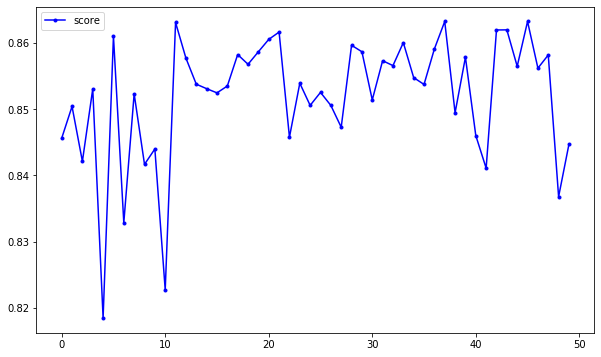

In [54]:
    x = np.arange(len(optimizer.res))
    y = [y["target"] for y in optimizer.res]
    fig, ax = plt.subplots(figsize=(10,6), sharex=True)
    ax.plot(x, y,'b', marker='.', label="score")
    ax.legend()

FloatProgress(value=0.0, max=201.0)

epoch 1
train: loss 0.6935, acc = 0.4993, precision = 1.0000, recall = 0.4994
test:  loss 0.6934, acc = 0.5007, precision = 1.0000, recall = 0.5007, time= 0.0007822513580322266
epoch 2
train: loss 0.5586, acc = 0.7291, precision = 0.7888, recall = 0.7043
test:  loss 0.5587, acc = 0.7283, precision = 0.7871, recall = 0.7047, time= 0.0007796287536621094
epoch 3
train: loss 0.4574, acc = 0.8107, precision = 0.7878, recall = 0.8252
test:  loss 0.4577, acc = 0.8099, precision = 0.7858, recall = 0.8260, time= 0.0007913112640380859
epoch 4
train: loss 0.4363, acc = 0.8201, precision = 0.8095, recall = 0.8266
test:  loss 0.4372, acc = 0.8191, precision = 0.8075, recall = 0.8271, time= 0.0007746219635009766
epoch 5
train: loss 0.4211, acc = 0.8291, precision = 0.8214, recall = 0.8339
test:  loss 0.4225, acc = 0.8279, precision = 0.8192, recall = 0.8342, time= 0.0007839202880859375
epoch 6
train: loss 0.4111, acc = 0.8345, precision = 0.8345, recall = 0.8342
test:  loss 0.4123, acc = 0.8334, pre

epoch 48
train: loss 0.3593, acc = 0.8543, precision = 0.9040, recall = 0.8220
test:  loss 0.3605, acc = 0.8539, precision = 0.9033, recall = 0.8223, time= 0.0007812976837158203
epoch 49
train: loss 0.3557, acc = 0.8564, precision = 0.8958, recall = 0.8300
test:  loss 0.3568, acc = 0.8562, precision = 0.8947, recall = 0.8311, time= 0.0007693767547607422
epoch 50
train: loss 0.3517, acc = 0.8582, precision = 0.8884, recall = 0.8375
test:  loss 0.3531, acc = 0.8579, precision = 0.8870, recall = 0.8385, time= 0.0007781982421875
epoch 51
train: loss 0.3564, acc = 0.8561, precision = 0.8697, recall = 0.8464
test:  loss 0.3579, acc = 0.8555, precision = 0.8685, recall = 0.8468, time= 0.0007658004760742188
epoch 52
train: loss 0.3499, acc = 0.8592, precision = 0.8838, recall = 0.8421
test:  loss 0.3516, acc = 0.8588, precision = 0.8827, recall = 0.8428, time= 0.0007846355438232422
epoch 53
train: loss 0.3496, acc = 0.8595, precision = 0.8850, recall = 0.8417
test:  loss 0.3516, acc = 0.8589, 

epoch 95
train: loss 0.3482, acc = 0.8598, precision = 0.8805, recall = 0.8452
test:  loss 0.3500, acc = 0.8594, precision = 0.8792, recall = 0.8461, time= 0.0009765625
epoch 96
train: loss 0.3480, acc = 0.8598, precision = 0.8854, recall = 0.8419
test:  loss 0.3497, acc = 0.8596, precision = 0.8843, recall = 0.8431, time= 0.0009987354278564453
epoch 97
train: loss 0.3484, acc = 0.8596, precision = 0.8831, recall = 0.8432
test:  loss 0.3503, acc = 0.8593, precision = 0.8817, recall = 0.8443, time= 0.0009794235229492188
epoch 98
train: loss 0.3481, acc = 0.8596, precision = 0.8866, recall = 0.8409
test:  loss 0.3497, acc = 0.8595, precision = 0.8855, recall = 0.8421, time= 0.0010216236114501953
epoch 99
train: loss 0.3482, acc = 0.8596, precision = 0.8802, recall = 0.8450
test:  loss 0.3501, acc = 0.8593, precision = 0.8790, recall = 0.8459, time= 0.0007884502410888672
epoch 100
train: loss 0.3484, acc = 0.8598, precision = 0.8791, recall = 0.8462
test:  loss 0.3502, acc = 0.8596, preci

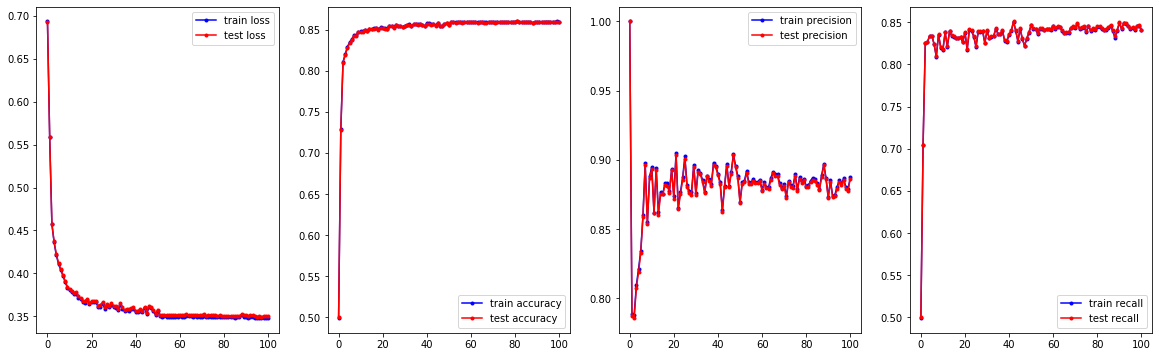

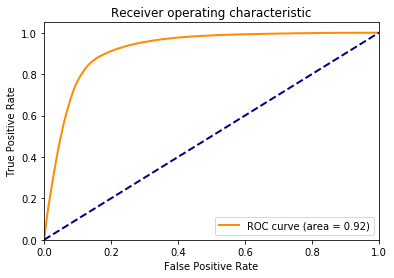

epoch 102
train: loss 0.3475, acc = 0.8600, precision = 0.8854, recall = 0.8423
test:  loss 0.3492, acc = 0.8600, precision = 0.8841, recall = 0.8437, time= 0.0007712841033935547
epoch 103
train: loss 0.3475, acc = 0.8600, precision = 0.8859, recall = 0.8419
test:  loss 0.3492, acc = 0.8599, precision = 0.8847, recall = 0.8432, time= 0.0007588863372802734
epoch 104
train: loss 0.3474, acc = 0.8601, precision = 0.8841, recall = 0.8433
test:  loss 0.3492, acc = 0.8598, precision = 0.8827, recall = 0.8444, time= 0.0007803440093994141
epoch 105
train: loss 0.3474, acc = 0.8600, precision = 0.8855, recall = 0.8422
test:  loss 0.3492, acc = 0.8599, precision = 0.8842, recall = 0.8435, time= 0.0007865428924560547
epoch 106
train: loss 0.3475, acc = 0.8600, precision = 0.8843, recall = 0.8431
test:  loss 0.3493, acc = 0.8599, precision = 0.8829, recall = 0.8444, time= 0.0007760524749755859
epoch 107
train: loss 0.3475, acc = 0.8601, precision = 0.8819, recall = 0.8447
test:  loss 0.3492, acc =

epoch 148
train: loss 0.3472, acc = 0.8601, precision = 0.8844, recall = 0.8431
test:  loss 0.3489, acc = 0.8599, precision = 0.8830, recall = 0.8444, time= 0.0007874965667724609
epoch 149
train: loss 0.3471, acc = 0.8602, precision = 0.8850, recall = 0.8429
test:  loss 0.3489, acc = 0.8600, precision = 0.8837, recall = 0.8440, time= 0.0007524490356445312
epoch 150
train: loss 0.3471, acc = 0.8603, precision = 0.8847, recall = 0.8433
test:  loss 0.3489, acc = 0.8600, precision = 0.8831, recall = 0.8444, time= 0.0007810592651367188
epoch 151
train: loss 0.3472, acc = 0.8603, precision = 0.8813, recall = 0.8454
test:  loss 0.3489, acc = 0.8600, precision = 0.8800, recall = 0.8465, time= 0.0007696151733398438
epoch 152
train: loss 0.3470, acc = 0.8603, precision = 0.8839, recall = 0.8437
test:  loss 0.3487, acc = 0.8599, precision = 0.8822, recall = 0.8449, time= 0.0007758140563964844
epoch 153
train: loss 0.3470, acc = 0.8602, precision = 0.8845, recall = 0.8432
test:  loss 0.3487, acc =

epoch 194
train: loss 0.3469, acc = 0.8603, precision = 0.8840, recall = 0.8436
test:  loss 0.3486, acc = 0.8600, precision = 0.8825, recall = 0.8449, time= 0.0007827281951904297
epoch 195
train: loss 0.3469, acc = 0.8603, precision = 0.8839, recall = 0.8438
test:  loss 0.3486, acc = 0.8601, precision = 0.8822, recall = 0.8451, time= 0.0007524490356445312
epoch 196
train: loss 0.3469, acc = 0.8603, precision = 0.8843, recall = 0.8434
test:  loss 0.3486, acc = 0.8600, precision = 0.8827, recall = 0.8447, time= 0.0007865428924560547
epoch 197
train: loss 0.3469, acc = 0.8602, precision = 0.8848, recall = 0.8431
test:  loss 0.3486, acc = 0.8601, precision = 0.8833, recall = 0.8444, time= 0.0007739067077636719
epoch 198
train: loss 0.3469, acc = 0.8603, precision = 0.8836, recall = 0.8440
test:  loss 0.3487, acc = 0.8600, precision = 0.8819, recall = 0.8452, time= 0.0007784366607666016
epoch 199
train: loss 0.3469, acc = 0.8602, precision = 0.8845, recall = 0.8433
test:  loss 0.3486, acc =

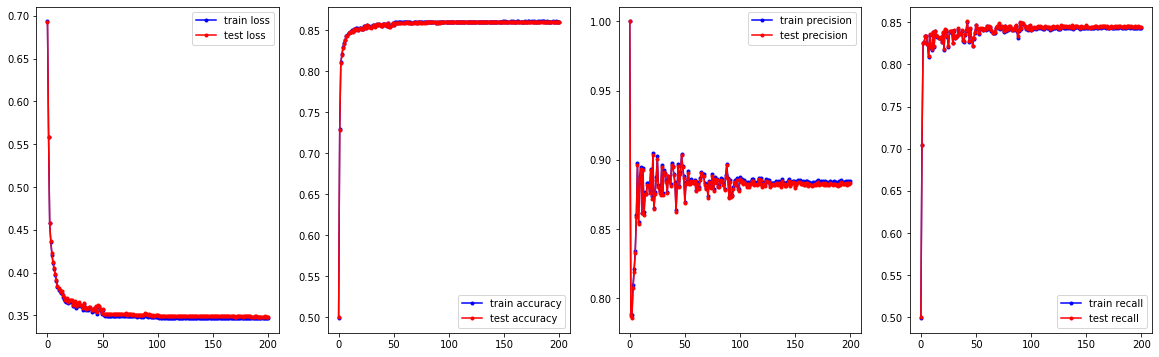

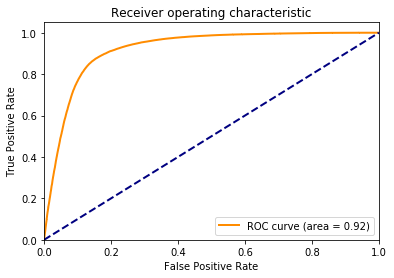

In [55]:
params = {'batch_size': 16303, 'center_hiden': 5, 'first_hiden': 13, 'last_hiden': 9, 'lr': 0.009064428433095639, 'n_hiden': 4}
test_model, stat_dict = fit_with(epochs=201, **params, return_model=True, verbose=1)

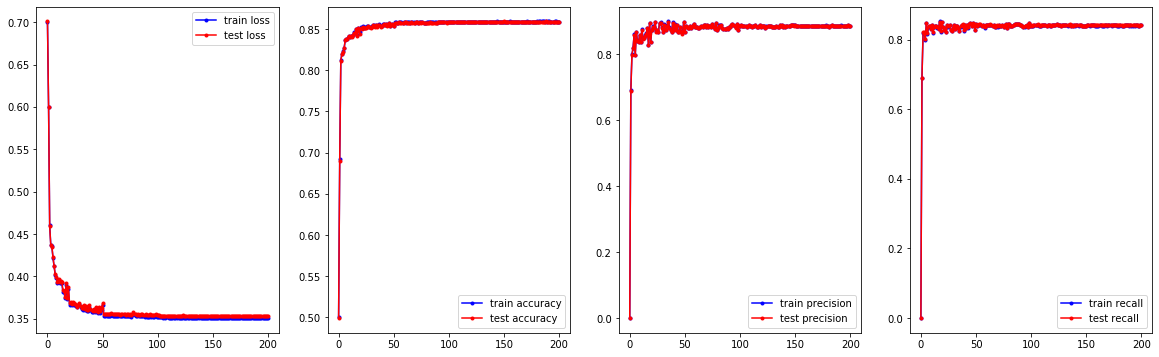

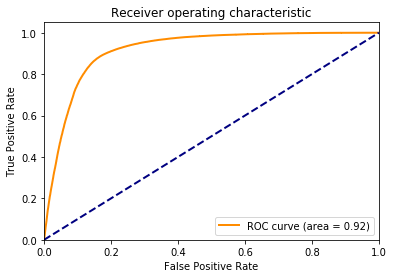

In [49]:
plot_training_classification(stat_dict)
auc_val = plot_roc(X_test, y_test, test_model)

In [50]:
test_model.hidden_number


20